In [1]:
import pickle
from numbers import Integral

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotnine import *
from scipy.linalg import solve_triangular
from scipy.special import erfinv
from sklearn.datasets import load_digits, make_moons

In [2]:
%matplotlib inline

In [3]:
theme_set(theme_bw())

# Exercise 1 - 2D data

Using a 2-dimensional training data sets of variying sizes, implement and train the following models:

1. 2D histogram
2. single Gaussian
3. Gaussian Mixture Model
4. Kernel Density Estimation with squared exponential kernel

In [4]:
def mvn_density(x, mean, cov):
    chol = np.linalg.cholesky(cov)
    residuals = mean - x
    quad = np.sum(solve_triangular(chol, residuals.T, lower=True) ** 2, axis=0)
    det = np.prod(np.diagonal(chol)) ** 2

    return 1 / np.sqrt((2 * np.pi) ** x.shape[1] * det) * np.exp(-0.5 * quad)


def mvn_sample(mean, cov, size=None, rng=np.random.default_rng()):
    if size is None:
        size = (1,)
    elif isinstance(size, Integral):
        size = (size,)
    size = (*size, mean.size)
    q = rng.uniform(0, 1, size=size)
    stdnorm = np.sqrt(2) * erfinv(2 * q - 1)

    chol = np.linalg.cholesky(cov)
    samples = (chol @ stdnorm[..., None]).squeeze(-1) + mean
    return samples.squeeze(0) if samples.shape[0] == 1 else samples

In [5]:
from abc import ABC, abstractmethod


class Model(ABC):
    @abstractmethod
    def train(self, data, **kwargs):
        pass

    @abstractmethod
    def sample(self, n_samples, rng):
        pass

    @abstractmethod
    def density(self, coords):
        pass

## 1. 2D Histogram

- define lower bound: $x_{min} = min_i x_i$, upper bound: $x_{max} = max_i x_i$
- pick a binsize:  $h$
- compute the nuber of bins $L = \frac{x_{max} - x_{min}}{h}$

$\hat{p}(x) = \sum_{l=1} \mathbb{I}[x_i \in bin_l] \frac{N_l}{N_h}$

In [6]:
class Histogram(Model):
    def __init__(self, binsize: float):
        super().__init__()
        self._binsize = binsize
        self._counts = None
        self._totalcounts = None
        self._cuts = None

    def _find_bin(self, coords):
        return [np.searchsorted(dcuts, coords[:, d], side="right") - 1 for d, dcuts in enumerate(self._cuts)]

    def train(self, data):
        mins = np.min(data, axis=0)
        maxs = np.max(data, axis=0)
        self._cuts = [None] * data.shape[1]
        for d, (min, max) in enumerate(zip(mins, maxs)):
            nbins = int((max - min) // self._binsize) + 1
            self._cuts[d] = np.linspace(min, min + nbins * self._binsize, num=nbins)
        self._counts = np.zeros([bins.size - 1 for bins in self._cuts], dtype=np.uint32)

        bins = self._find_bin(data)
        for i in range(data.shape[0]):
            self._counts[*(bin[i] for bin in bins)] += 1
        self._totalcounts = self._counts.sum()

    def sample(self, n_samples, rng=np.random.default_rng()):
        samples = np.empty((n_samples, len(self._counts.shape)), dtype=np.float32)
        binidx = rng.multinomial(1, self._counts.reshape(-1) / self._counts.sum(), size=(n_samples,)).argmax(axis=-1)
        binidx = np.unravel_index(binidx, self._counts.shape, order="C" if self._counts.flags.c_contiguous else "F")
        for d, dcuts in enumerate(self._cuts):
            samples[:, d] = rng.uniform(dcuts[binidx[d]], dcuts[binidx[d] + 1])
        return samples

    def density(self, coords):
        bins = self._find_bin(coords)
        density = np.empty((coords.shape[0],), dtype=np.float32)
        idx = np.any([(bin < 0) | (bin >= d) for bin, d in zip(bins, self._counts.shape)], axis=0)
        density[idx] = 0
        density[~idx] = self._counts[*(bin[~idx] for bin in bins)] / (self._totalcounts * self._binsize**2)
        return density

## 2. Single Gaussian

In [7]:
class Gaussian(Model):
    def __init__(self):
        self._mean = None
        self._cov = None

    def train(self, data):
        self._mean = np.mean(data, axis=0)
        self._cov = np.cov(data, rowvar=False)

    def sample(self, n_samples, rng=np.random.default_rng()):
        return mvn_sample(self._mean, self._cov, size=n_samples, rng=rng)

    def density(self, coords):
        return mvn_density(coords, self._mean, self._cov)

## 3. Gaussian Mixture Model

$p(x) = \sum_l^L \pi_l p_l(x)$ where $\pi_l \geq 0$ and $\sum_l^L{\pi_l} = 1$ 

$p_l(x) = \mathcal{N}(x|\mu_l, \Sigma_l)  $

Task: learn $\mu_l$, $\sigma_l$ and $\pi_l$ for each component $l$. 

#### EM algorithm

Fix L as a hyperparameter

0. initialization:

    * select $\mu_l^{(0)}$ randomly
    * $\Sigma_l = \tau_l$ with $\tau_l^{(0)} = I$
    * $\pi_l^{(0)} = \frac{1}{L}$


1. for $t = 1, ..., T$:

    a. $\gamma_{il} = p^{(t-1)}(x_i \in cluster \; l| x_i) = \frac{\pi_l^{(t-1)}p_l(x_i)}{\sum_{l=1}^L \pi_{l'}^{(t-1)}p_{l'}^{(t-1)}(x_i)} = \frac{\pi_l^{(t-1)}\mathcal{N}(x_i|\mu_l^{(t-1)}, \tau^{(t-1)}_l)}{\sum_{l=1}^L \pi_{l'}^{(t-1)}\mathcal{N}(x_i|\mu_{l'}^{(t-1)}, \tau^{(t-1)}_{l'})} $

    b. update $\mu_l$ and $\tau_l$: 

    $\mu_l^{(t)} = \frac{\sum_{i=1}^N\gamma_{il}x_i}{\sum_{i=1}^N\gamma_{il}}$
    
    $\tau_l^{(t)} = \frac{\sum_{i=1}^N \gamma_{il}(x_i - \mu_l^{(t)})(x_i - \mu_l^{(t)})^T}{\sum_{i=1}^N \gamma_{il}}$
    
    c. update $\pi_l$:
   
    $\pi_l^{(t)} = \frac{1}{N}\sum_{i=1}^N \gamma_{il}$

In [8]:
class GaussianMixture(Model):
    def __init__(self, k):
        super().__init__()
        self._k = k
        self._pi = None  # (k,)
        self._means = None  # (k, dim)
        self._covs = None  # (k, dim, dim)
        self._converged = False
        self._niter = np.inf

    def _densities(self, data):
        return [self._pi[k] * mvn_density(data, self._means[k, :], self._covs[k, ...]) for k in range(self._k)]

    def train(self, data, niter=1000, abstol=1e-6, reltol=1e-6, eps=1e-9, rng=np.random.default_rng()):
        self._pi = rng.dirichlet(np.ones((self._k,)), size=1).squeeze(0)
        self._means = rng.uniform(np.min(data, axis=0), np.max(data, axis=0), size=(self._k, data.shape[1]))
        self._covs = np.tile(np.eye(data.shape[1]), (self._k, 1, 1))

        eps = eps * self._covs

        old_loglik = -np.inf
        for i in range(niter):
            pidens = np.stack(self._densities(data), axis=1)  # (n, k)
            loglik = np.sum(np.log(np.sum(pidens, axis=1)))
            if i > 0 and (np.abs(old_loglik - loglik) < abstol or np.abs((old_loglik - loglik) / old_loglik) < reltol):
                self._converged = True
                break
            old_loglik = loglik

            gamma = pidens / np.sum(pidens, axis=1)[:, None]  # (n, k)
            N_k = np.sum(gamma, axis=0)

            self._means = np.sum(gamma[..., None] * data[:, None, :], axis=0) / N_k[:, None]

            residuals = data[:, None, :] - self._means  # (n, k, dim)
            self._covs = (
                np.sum(residuals[..., None] * residuals[..., None, :] * gamma[..., None, None], axis=0)
                / N_k[:, None, None]
            ) + eps
            self._pi = N_k / data.shape[0]
        self._niter = i

    def sample(self, n_samples, rng=np.random.default_rng()):
        samples = np.empty((n_samples, self._covs.shape[-1]), dtype=np.float32)
        components = rng.multinomial(1, self._pi, size=(n_samples,)).astype(bool)
        for k in range(self._k):
            samples[components[:, k]] = mvn_sample(
                self._means[k, :], self._covs[k, ...], size=components[:, k].sum(), rng=rng
            )

        return samples

    def density(self, coords):
        return np.sum(self._densities(coords), axis=0)

    @property
    def converged(self):
        return self._converged

    @property
    def niter(self):
        return self._niter

## 4. Kernel density estimation

* With squared exponential kernel: 

$k(x, x')  = exp(- \frac{||x-x'||^2}{2l^2})$

* L = N

* $\mu_l = x_l$, $\pi_l  = \frac{1}{N}$

* $l$ is chosen as hyperparameter

In [9]:
class KDE(Model):
    def __init__(self, bw):
        super().__init__()
        self._bw = bw
        self._data = None

    def train(self, data):
        self._data = data.copy()

    def sample(self, n_samples, rng=np.random.default_rng()):
        samples = np.empty((n_samples, self._data.shape[1]), dtype=np.float32)
        components = rng.multinomial(
            1, np.full((self._data.shape[0],), 1 / self._data.shape[0]), size=(n_samples,)
        ).astype(bool)
        for i, x in enumerate(self._data):
            samples[components[:, i]] = mvn_sample(
                x, np.diagflat(np.full((self._data.shape[1],), self._bw)), size=components[:, i].sum(), rng=rng
            )
        return samples

    def density(self, coords):
        return (
            np.sum(
                [mvn_density(coords, x, np.diagflat(np.full((self._data.shape[1],), self._bw))) for x in self._data],
                axis=0,
            )
            / self._data.shape[0]
        )

## Maximum Mean Discrepancy (MMD)

The mean discrepancy can be used to evaluate the accuracy of the models. We calculate the MMD between a test data set and the data generated by the generative model

$MMD = \max_{\phi \in \mathcal{F}}[\frac{1}{M}\sum_i^M \phi(x_i) - \frac{1}{N} \sum_i^N \phi(x_i^*)]$

$MMD = 0$ means that $p(x) =p^*(x)$ 

We replace the explicit mapping $\phi(x)$ with a kernel function $k(X, X')$

$MMD^2 = \frac{1}{M(M-1)}\sum_{i=1}^M \sum_{i' \neq i} k(x_i, x_{i'}) + \frac{1}{N(N-1)} \sum_{i=1}^N \sum_{i' \neq i} k(x_i^*, x_{i'}^*) - \frac{2}{MN} \sum_{i=1}^M \sum_{i'=1}^N k(x_i , x_{i'}^*)$


Kernel functions:
- squared exponential 
$k(x, x')  = exp(- \frac{||x-x'||^2}{2l^2})$

- inverse multi-quadratic
$k(x, x') = \frac{1}{\frac{||x-x'||^2}{l} +1}$

The bandwidth hyperparameter $l$ should be adapted to the typical distance in the data set. 

In [10]:
def mmd(xx, xy, kern):
    A = kern(xx, xx)
    np.fill_diagonal(A, 0)
    A = A.sum() / (xx.shape[0] * (xx.shape[0] - 1))

    B = kern(xx, xy)
    B = 2 * B.sum() / (xx.shape[0] * xy.shape[0])

    C = kern(xy, xy)
    np.fill_diagonal(C, 0)
    C = C.sum() / (xy.shape[0] * (xy.shape[0] - 1))

    mmd = np.maximum(0, A - B + C)  # numerical error
    return np.sqrt(mmd)

In [11]:
class Kernel(ABC):
    @abstractmethod
    def __call__(self, xx, xy):
        pass

In [12]:
class SqExpKern(Kernel):
    def __init__(self, lengthscale):
        super().__init__()
        self._lengthscale = lengthscale

    def __call__(self, xx, xy):
        return np.exp(-np.sum((xx[:, None, :] - xy[None, ...]) ** 2, axis=-1) / (2 * self._lengthscale**2))

In [13]:
class MultiQuadKern(Kernel):
    def __init__(self, bw):
        super().__init__()
        self._bw = bw

    def __call__(self, xx, xy):
        return 1 / (np.sum((xx[:, None, :] - xy[None, ...]) ** 2, axis=-1) / self._bw + 1)

## Training & Test data

`make_moons` data set from sklearn.

In [14]:
training = make_moons(3000, noise=0.2, random_state=42)[0]
test = make_moons(1000, noise=0.2, random_state=1337)[0]

In [15]:
rng = np.random.default_rng(42)

### Evaluate the generative models

In [16]:
results = []
models = {}
mmd_bw = 0.1

training_sizes = np.round(np.linspace(0.1, 1, num=10) * training.shape[0]).astype(int)


def eval_model(modelcls, params, rng, train_kwargs=None):
    if train_kwargs is None:
        train_kwargs = {}
    cmodels = {}
    for param in params:
        for ts_size in training_sizes:
            model = modelcls(param) if param is not None else modelcls()
            model.train(training[:ts_size, :], **train_kwargs)
            msample = model.sample(test.shape[0], rng=rng)

            mmd_sqexp = mmd(test, msample, SqExpKern(mmd_bw))
            mmd_multiquad = mmd(test, msample, MultiQuadKern(mmd_bw))

            results.append(
                {
                    "model": model.__class__.__name__,
                    "ts_size": ts_size,
                    "param": param,
                    "mmd_sqexp": mmd_sqexp,
                    "mmd_multiquad": mmd_multiquad,
                }
            )
        cmodels[param] = model
    models[modelcls.__name__] = cmodels


eval_model(Histogram, np.linspace(0.005, 0.5, num=100), rng)
eval_model(Gaussian, (None,), rng)
eval_model(GaussianMixture, np.arange(1, 51), rng, {"rng": rng})
eval_model(KDE, np.linspace(0.001, 0.3, num=30), rng)

results = pd.DataFrame(results)

In [17]:
results.to_pickle("1_results.pkl")
pickle.dump(models, open("1_models.pkl", "wb"))

In [18]:
results = pd.read_pickle("1_results.pkl")
models = pickle.load(open("1_models.pkl", "rb"))

In [19]:
results = results.melt(id_vars=["model", "param", "ts_size"], var_name="mmd_type", value_name="mmd").assign(
    mmd_type=lambda x: x.mmd_type.str[4:]
)

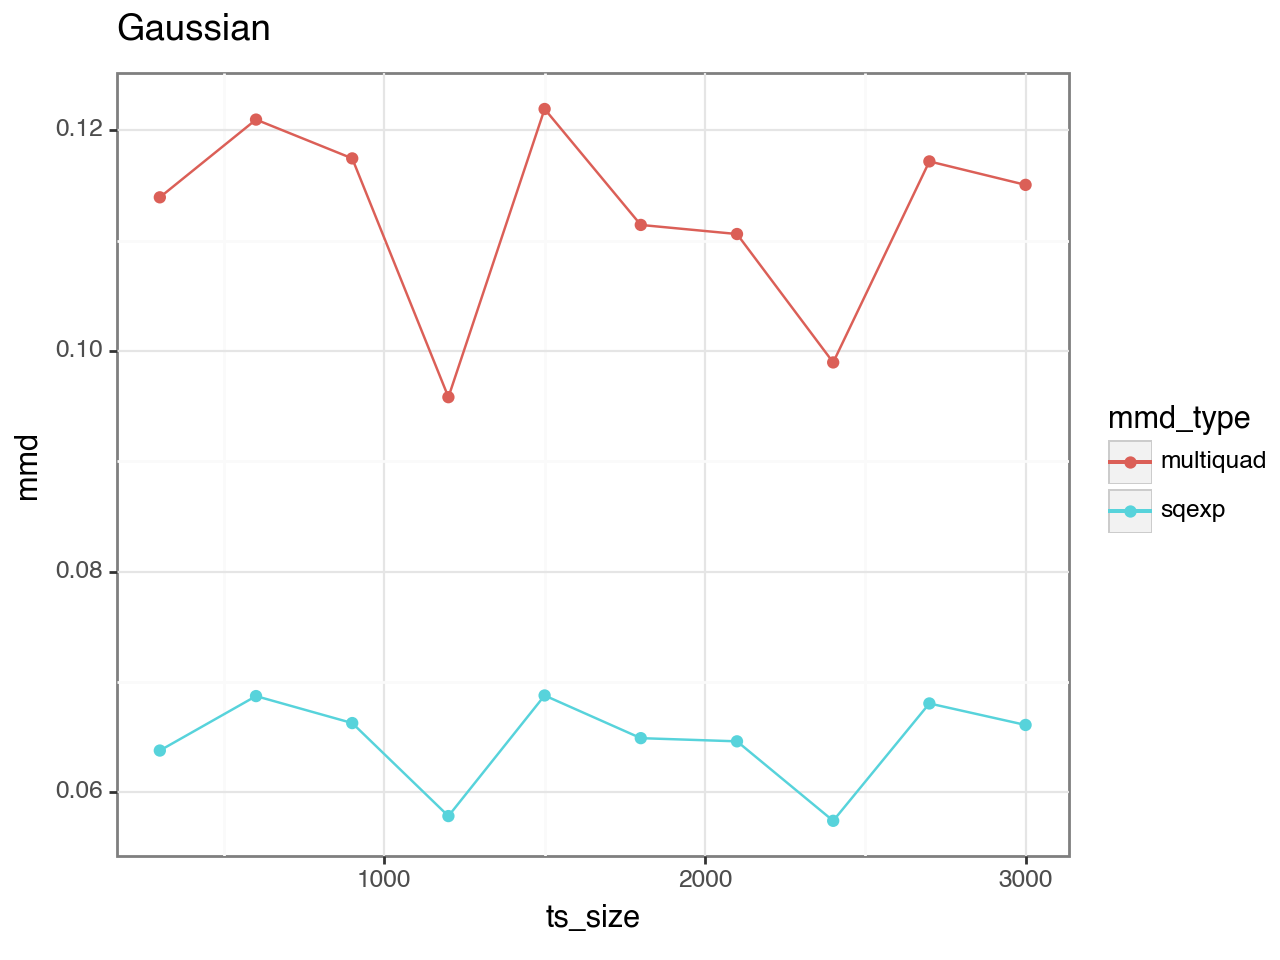

<Figure Size: (640 x 480)>

In [20]:
(
    ggplot(results.query("model == 'Gaussian'"), aes("ts_size", "mmd", color="mmd_type"))
    + geom_line()
    + geom_point()
    + ggtitle("Gaussian")
)

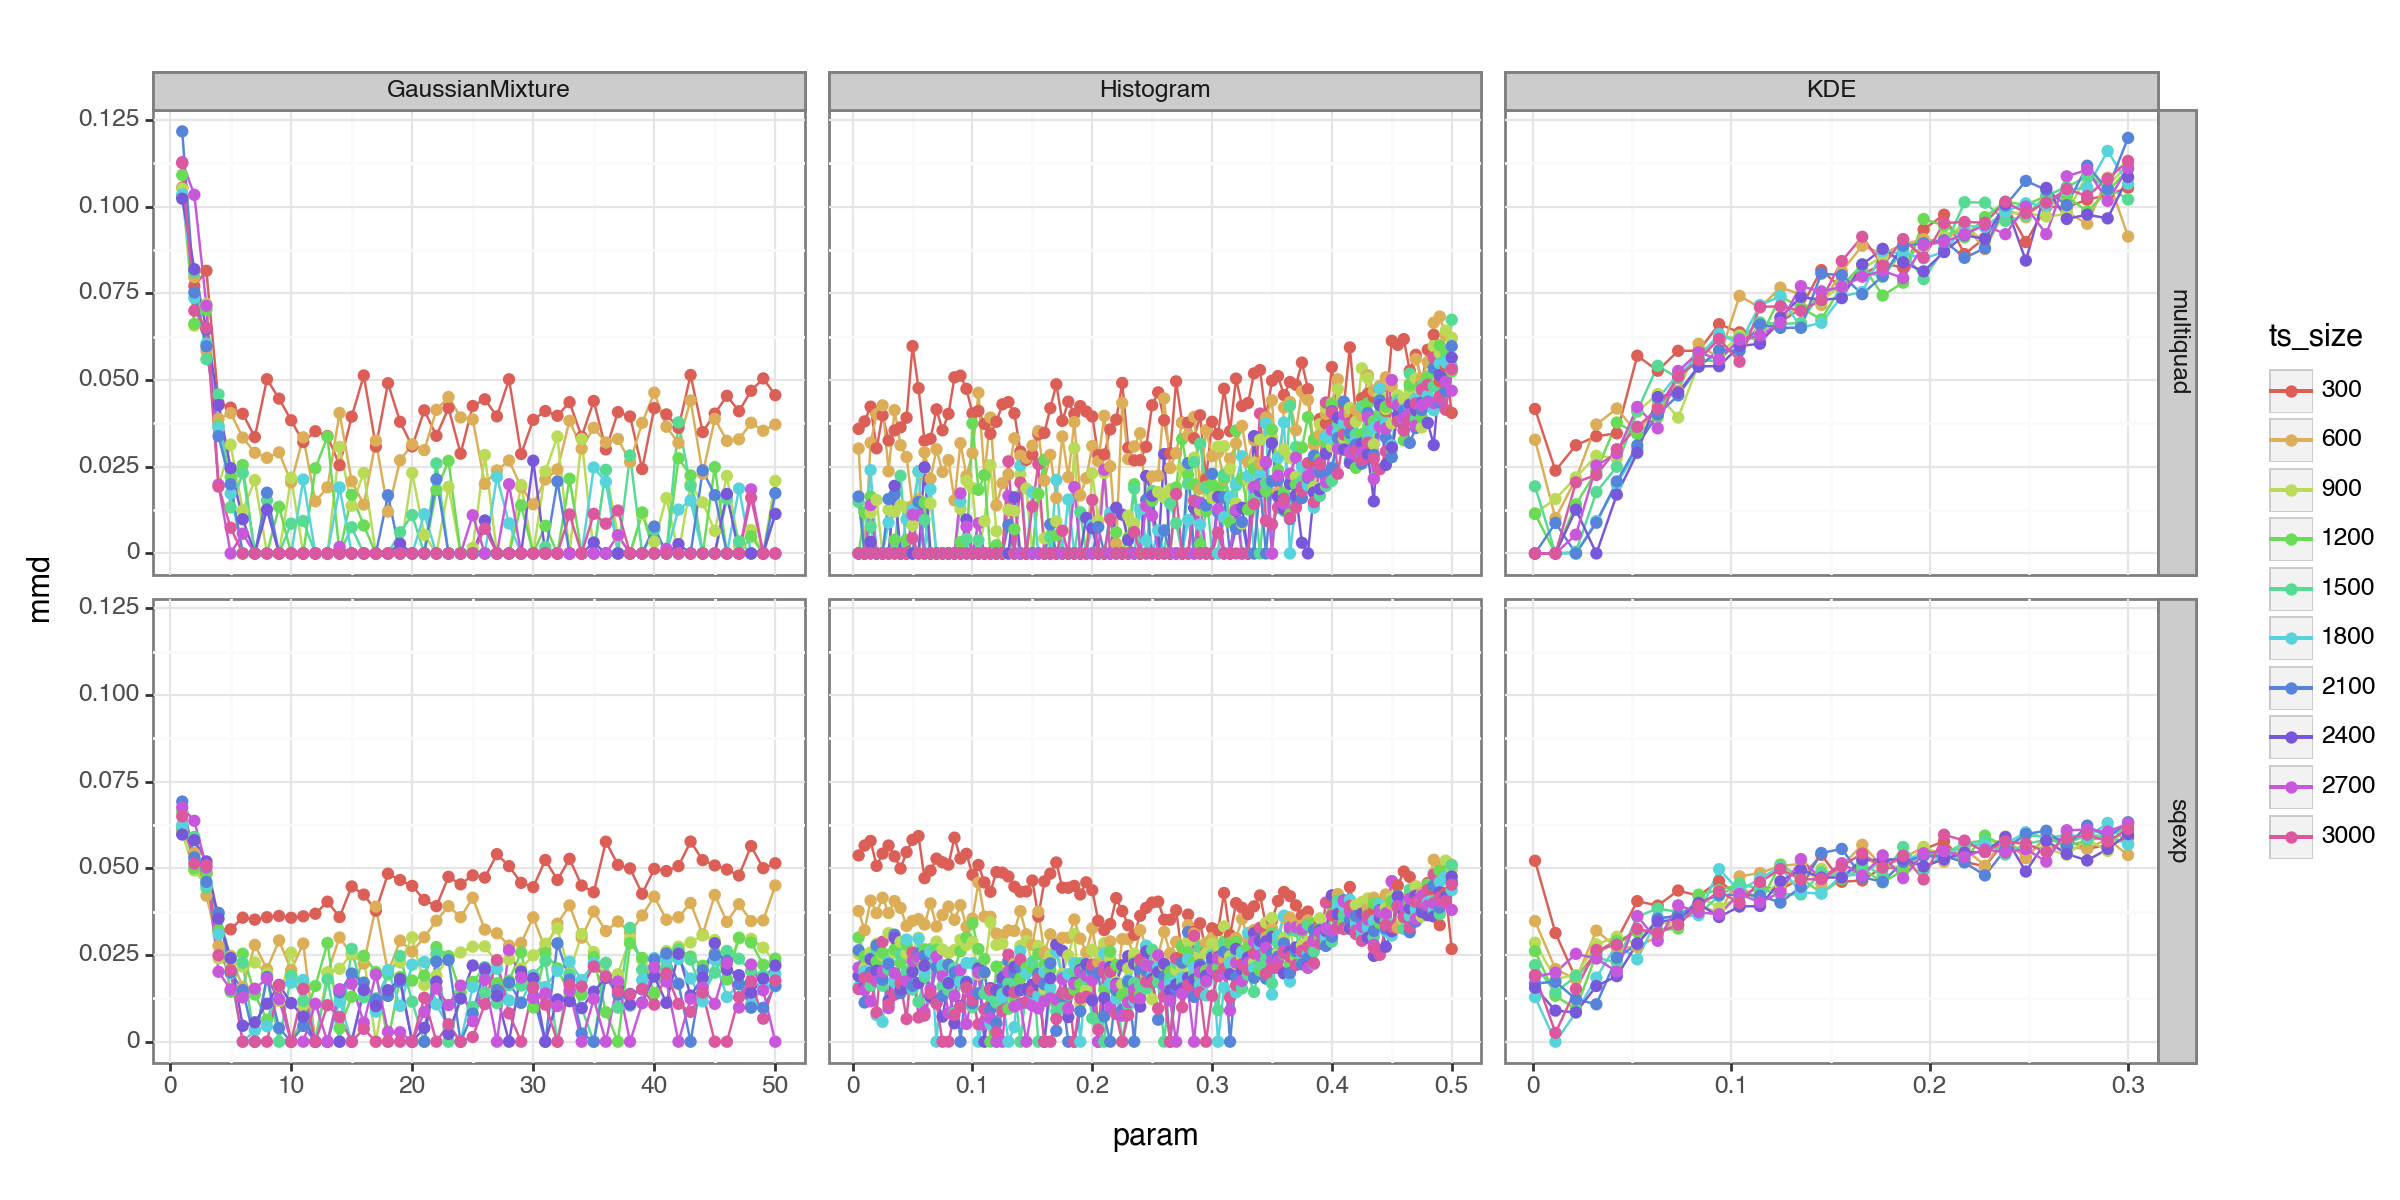

<Figure Size: (1200 x 600)>

In [21]:
(
    ggplot(
        results.query("model != 'Gaussian'").assign(ts_size=lambda x: pd.Categorical(x.ts_size)),
        aes("param", "mmd", color="ts_size"),
    )
    + geom_line()
    + geom_point()
    + facet_grid(("mmd_type", "model"), scales="free_x")
    + theme(figure_size=(12, 6))
)

As expected, increasing the training set size improves the models. However, the effect is only evident if the model's parameter is such that the model can be good, for other parameter settings there is no difference between training set sizes. This is particularly evident for kernel density estimation, which produces good models only in a very narrow bandwidth range.

The single Gaussian is the least accurate of all models (it has the highest MMD), which is expected as it does not match the distribution of the data at all.

The Gaussian mixture and the histogram are the most accurate models for a wide range of their respective parameter values. The GMM reaches a low MMD value at 6 components and plateaus, which means that 6 mixture components are sufficient to accurately model these data with his model. Interestingly, MMD with the squared exponential kernel slightly increases as the number of components goes beyond 15, but not MMD with the multi-quadratic kernel. Similarly, the histogram is most accurate for bis sizes smaller than approx. 0.25. For larger bin sizes, its accuracy declines. This is expected, as large bins cannot capture sharp changes in data density.

The KDE is most accurate only for very small kernel bandwidths up to approx. 0.03. For larger bin sizes, its MMD rapidly increases.

MMD with the multi-quadratic kernel appears to be more sensitive to changes in accuracy: It results in lower values than MMD with the squared exponential kernels for accurate models, but yields higher values for inaccurate models.

In the following, we always use models trained on the full training set.

In [22]:
def plot_model(model, title, rng=np.random.default_rng(), ntiles=100, nsamples=1000):
    ndata = model.sample(nsamples, rng)

    (xmin, ymin), (xmax, ymax) = ndata.min(0), ndata.max(0)
    xadd = (xmax - xmin) * 0.04
    yadd = (ymax - ymin) * 0.04
    xmin -= xadd
    xmax += xadd
    ymin -= yadd
    ymax += yadd

    coords = np.stack(
        [x.reshape(-1) for x in np.meshgrid(np.linspace(xmin, xmax, num=ntiles), np.linspace(ymin, ymax, num=ntiles))],
        axis=1,
    )
    density = model.density(coords).reshape((ntiles, ntiles))

    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
    fig.set_size_inches(10, 3)
    axs[0].scatter(ndata[:, 0], ndata[:, 1], alpha=0.5, edgecolors="none")
    axs[0].set_xlim(xmin, xmax)
    axs[0].set_ylim(ymin, ymax)
    axs[0].set_aspect(1, adjustable="box")

    img = axs[1].imshow(
        density,
        origin="lower",
        extent=[xmin, xmax, ymin, ymax],
    )

    l, b, w, h = axs[1].get_position().bounds
    cax = fig.add_axes((l + w + w * 0.01, b, w * 0.03, h))
    fig.colorbar(img, fraction=1, cax=cax)
    fig.suptitle(title)

Text(0.5, 0.98, 'training data set')

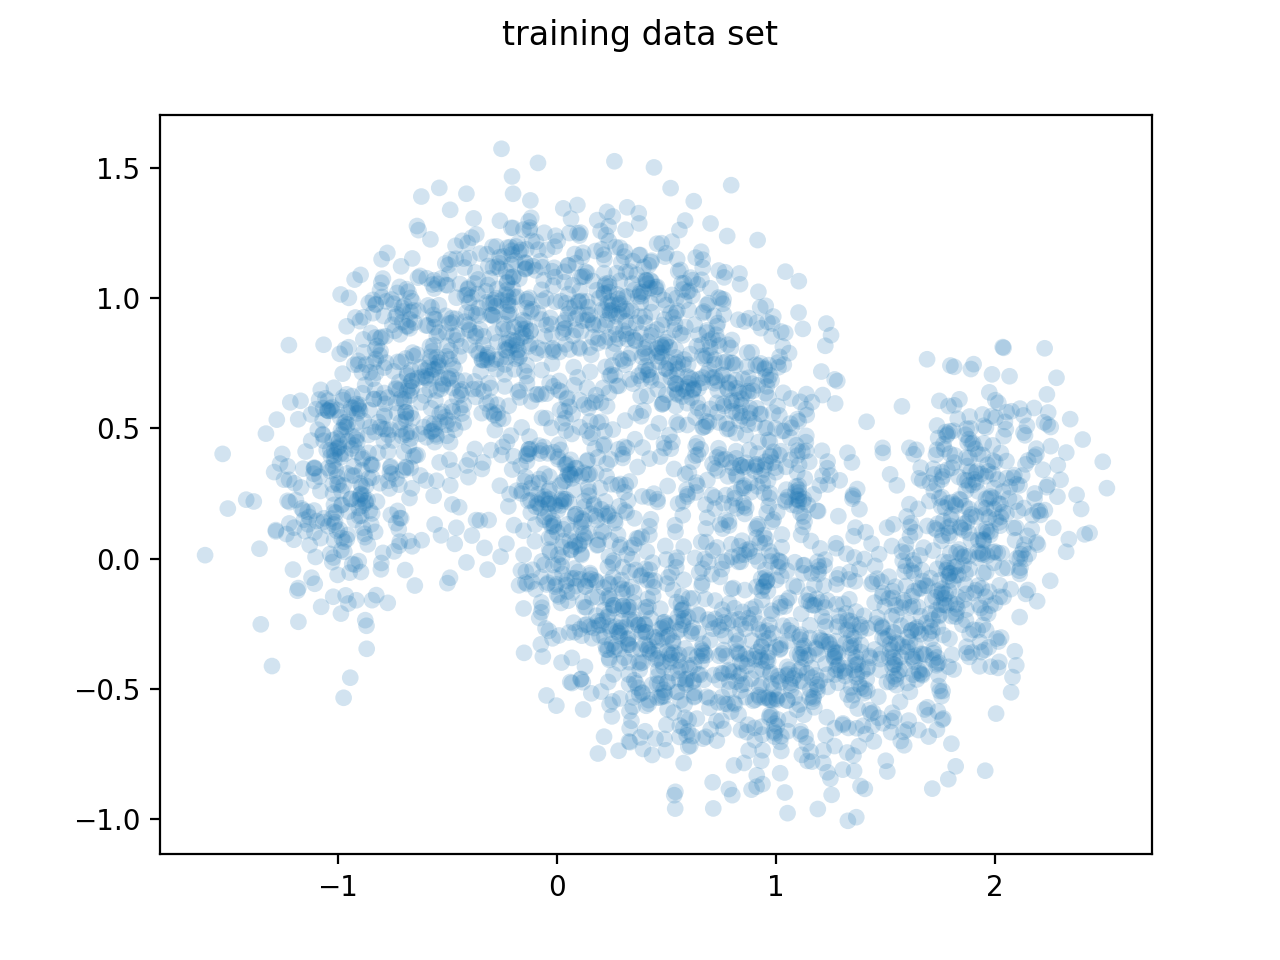

In [23]:
plt.scatter(training[:, 0], training[:, 1], alpha=0.2, edgecolors="none")
plt.suptitle("training data set")

### Learned density and generated datasets for different models

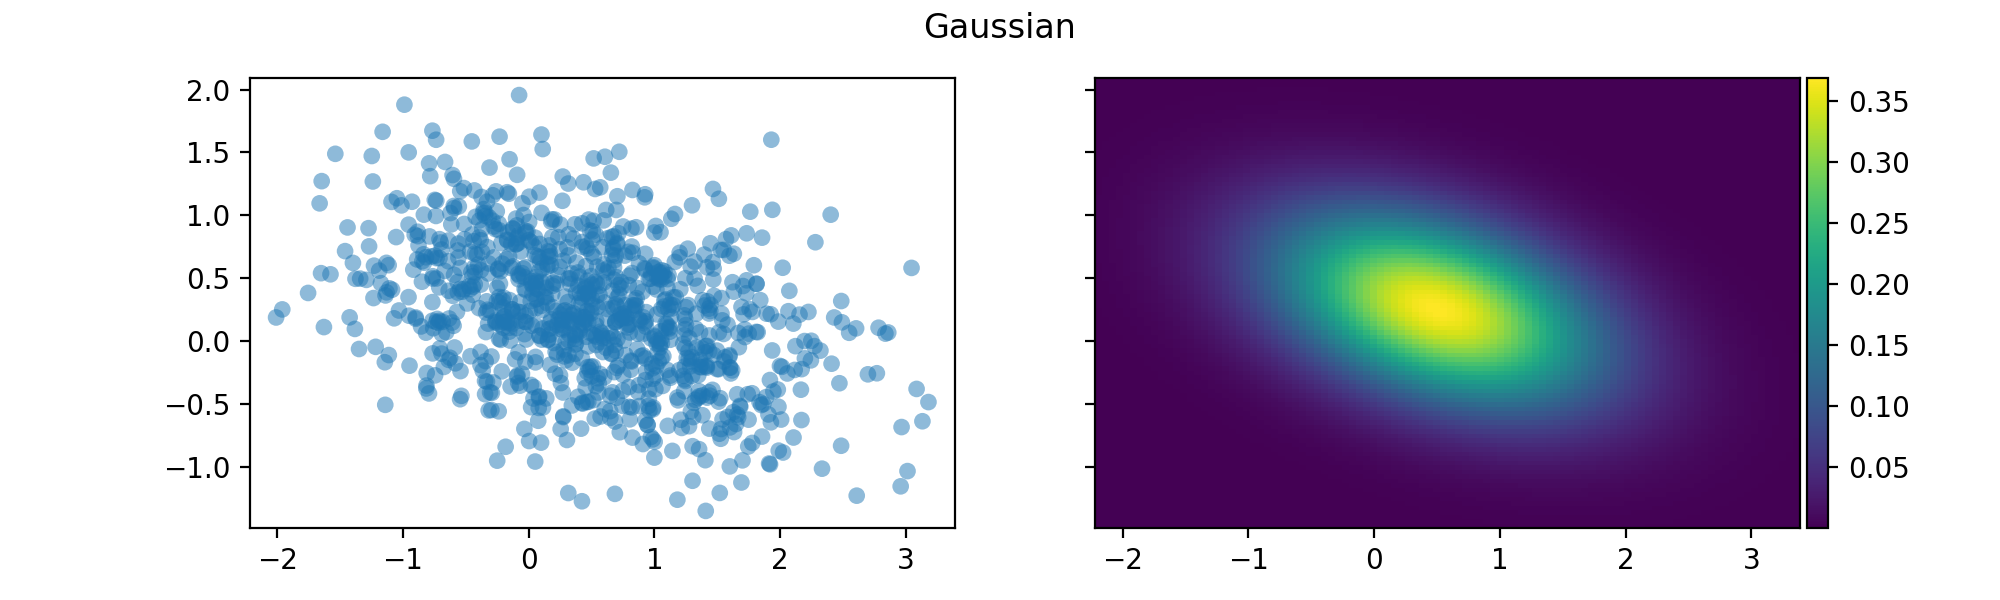

In [24]:
plot_model(models["Gaussian"][None], "Gaussian", rng)

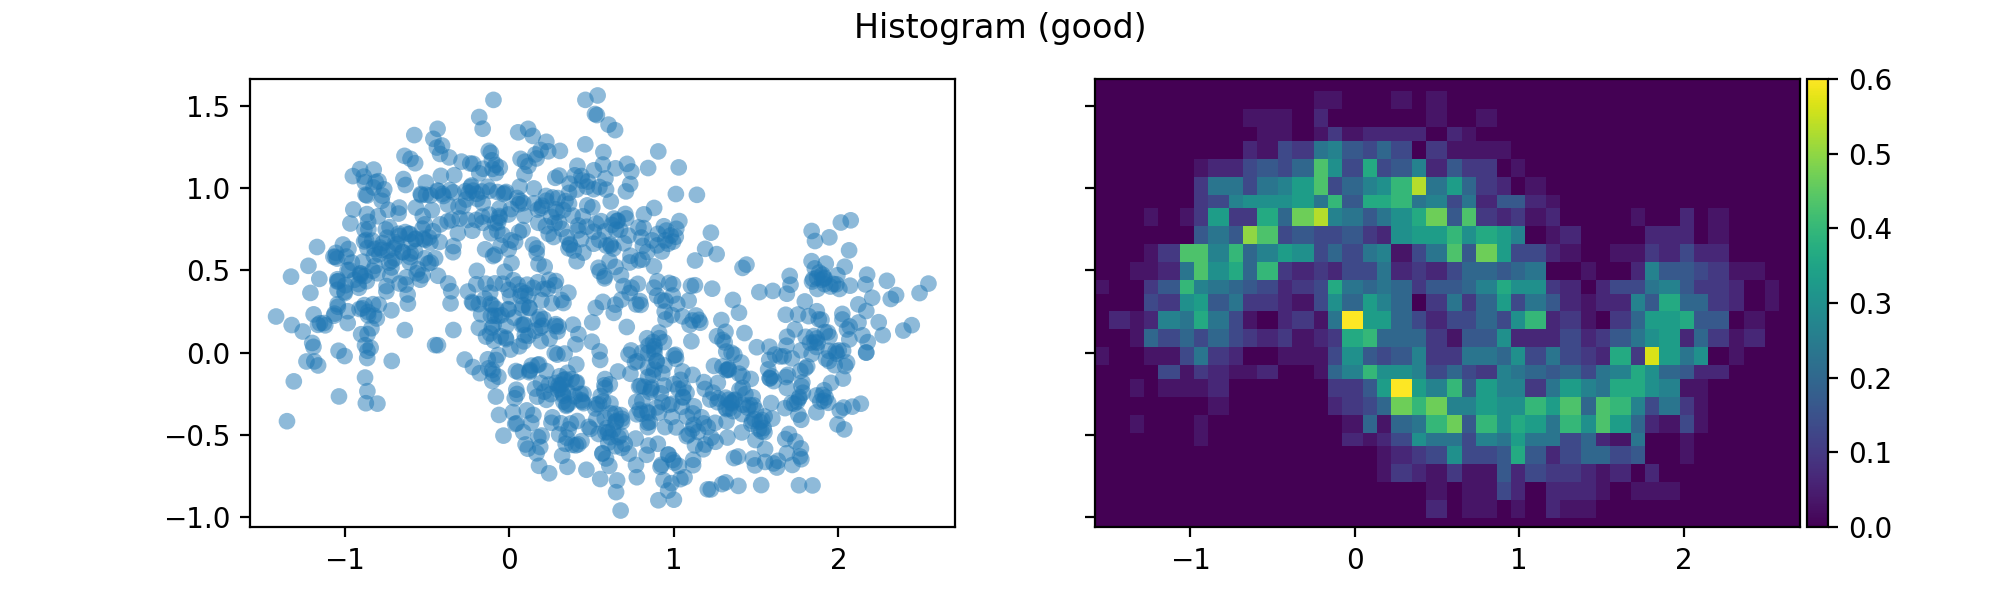

In [25]:
plot_model(models["Histogram"][0.1], "Histogram (good)", rng)

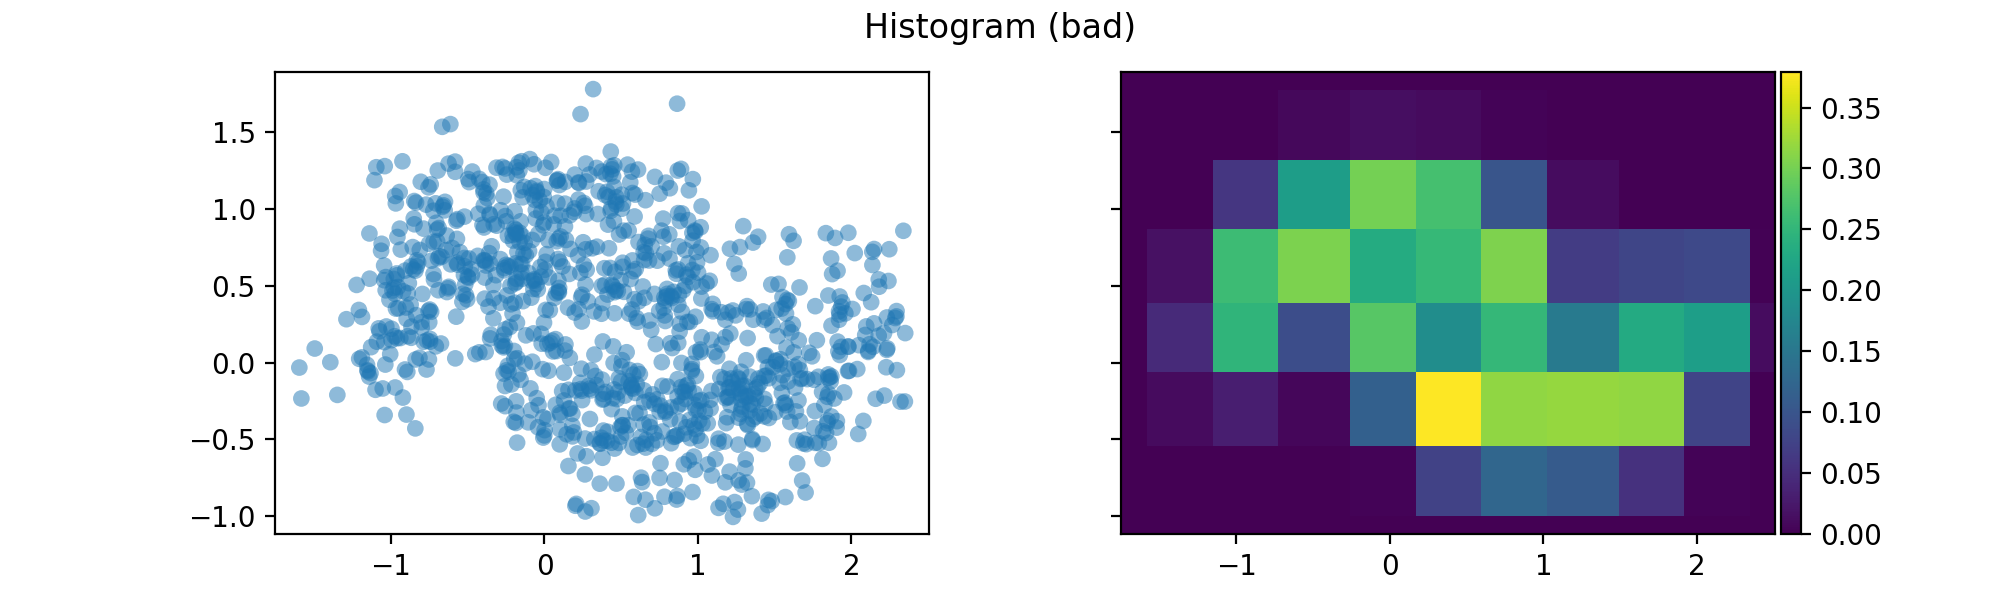

In [26]:
plot_model(models["Histogram"][0.4], "Histogram (bad)", rng)

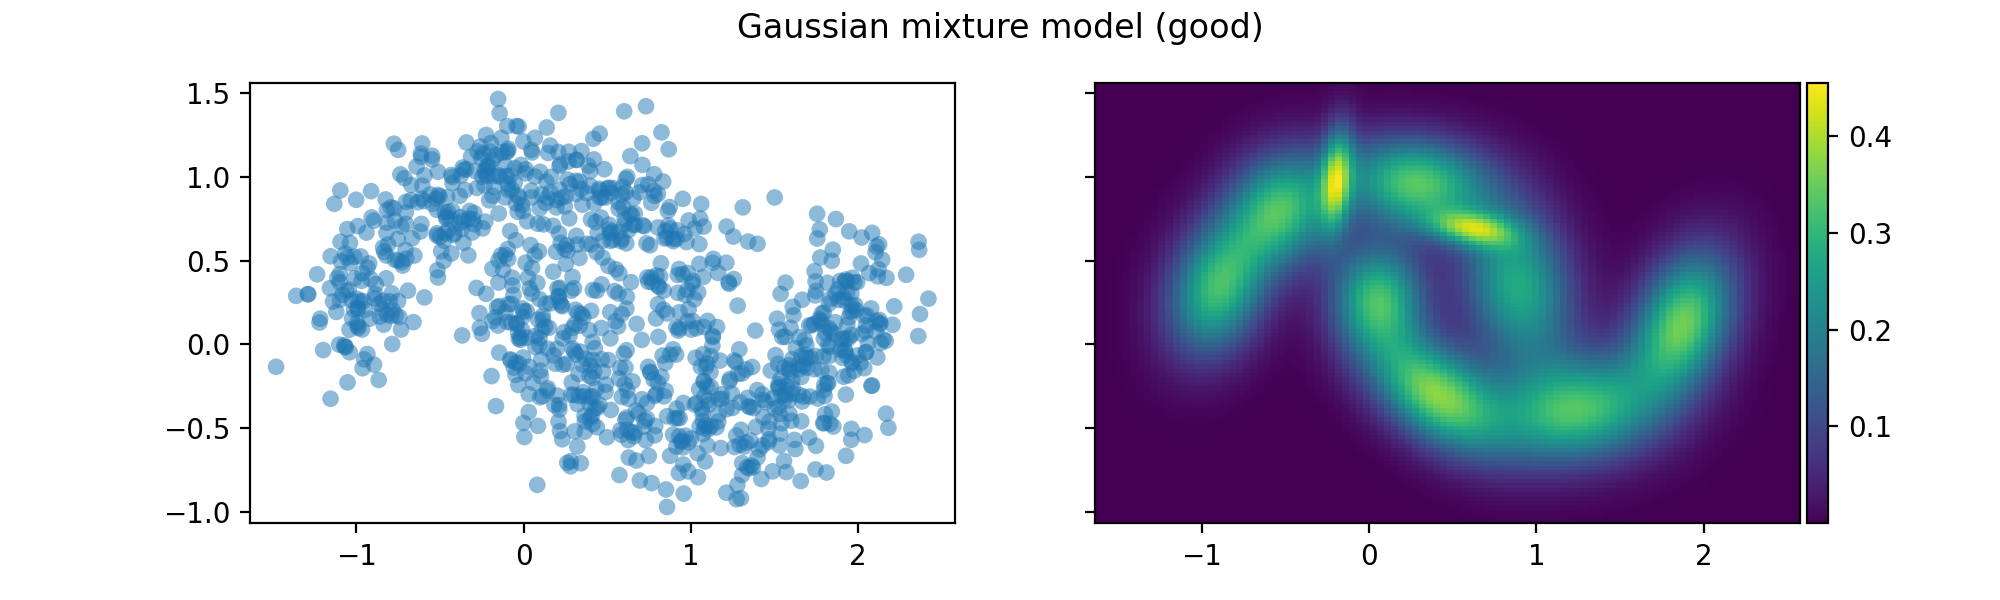

In [27]:
plot_model(models["GaussianMixture"][10], "Gaussian mixture model (good)", rng)

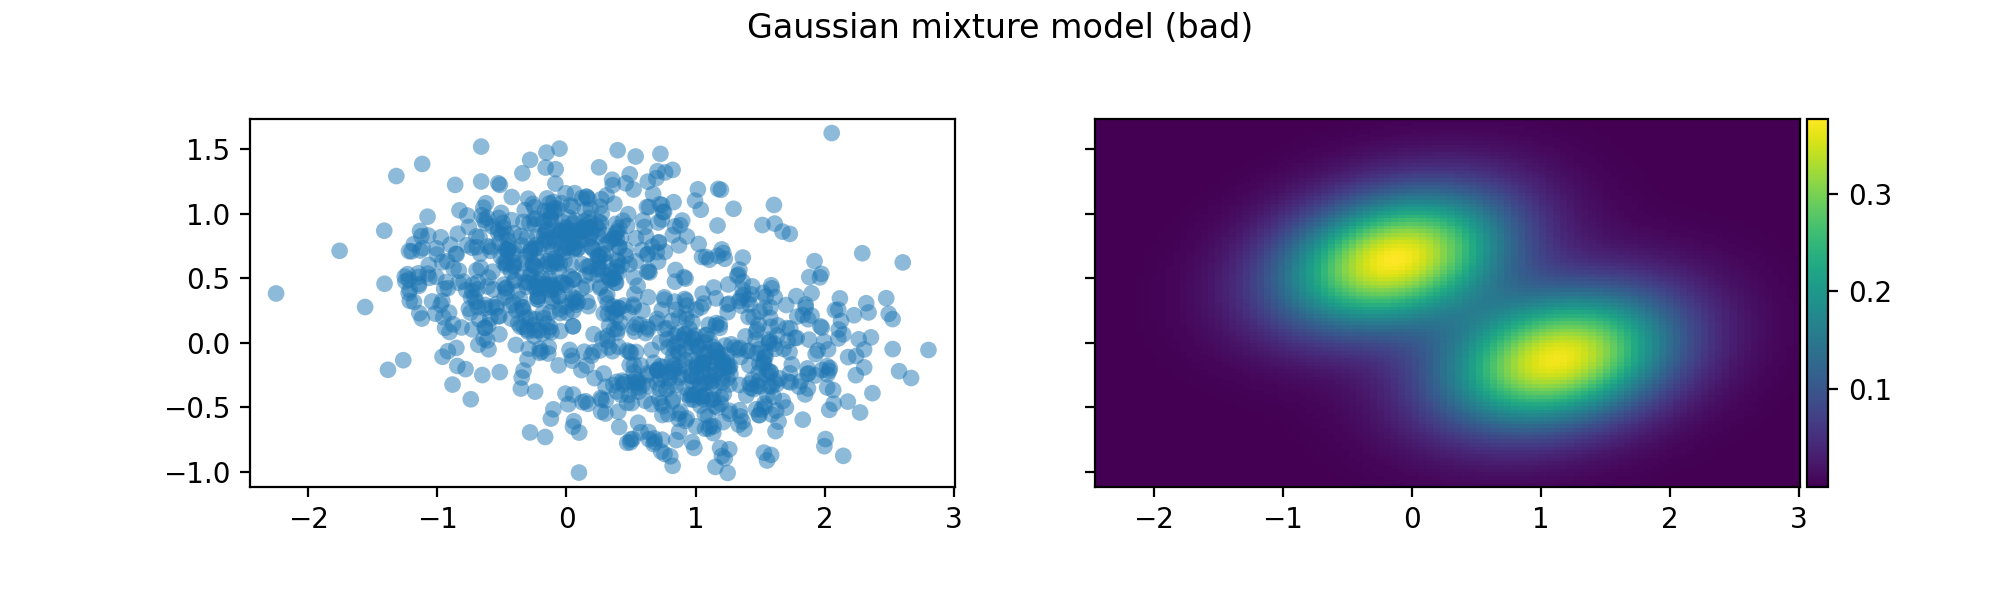

In [28]:
plot_model(models["GaussianMixture"][2], "Gaussian mixture model (bad)", rng)

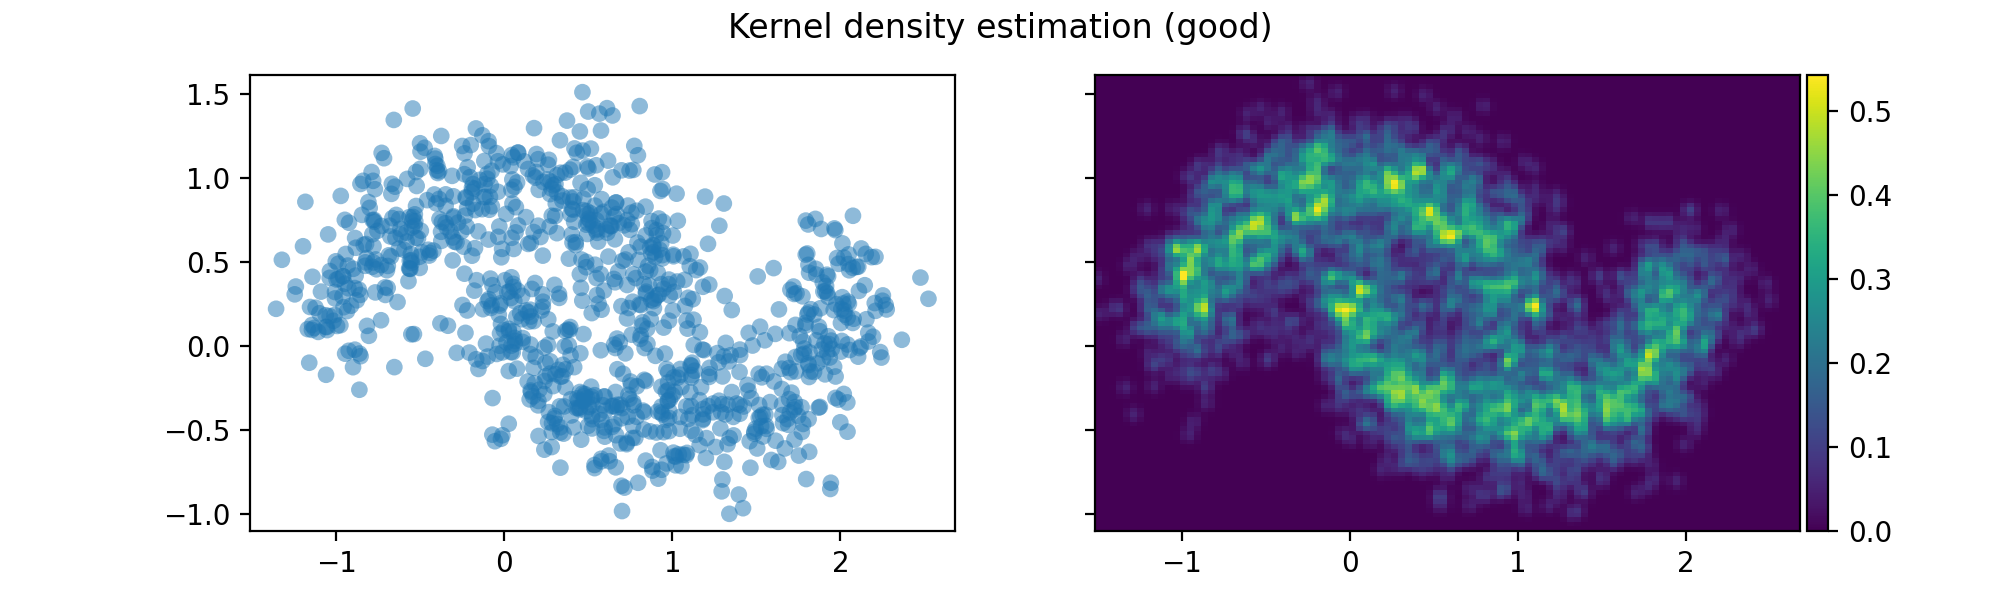

In [29]:
plot_model(models["KDE"][0.001], "Kernel density estimation (good)", rng)

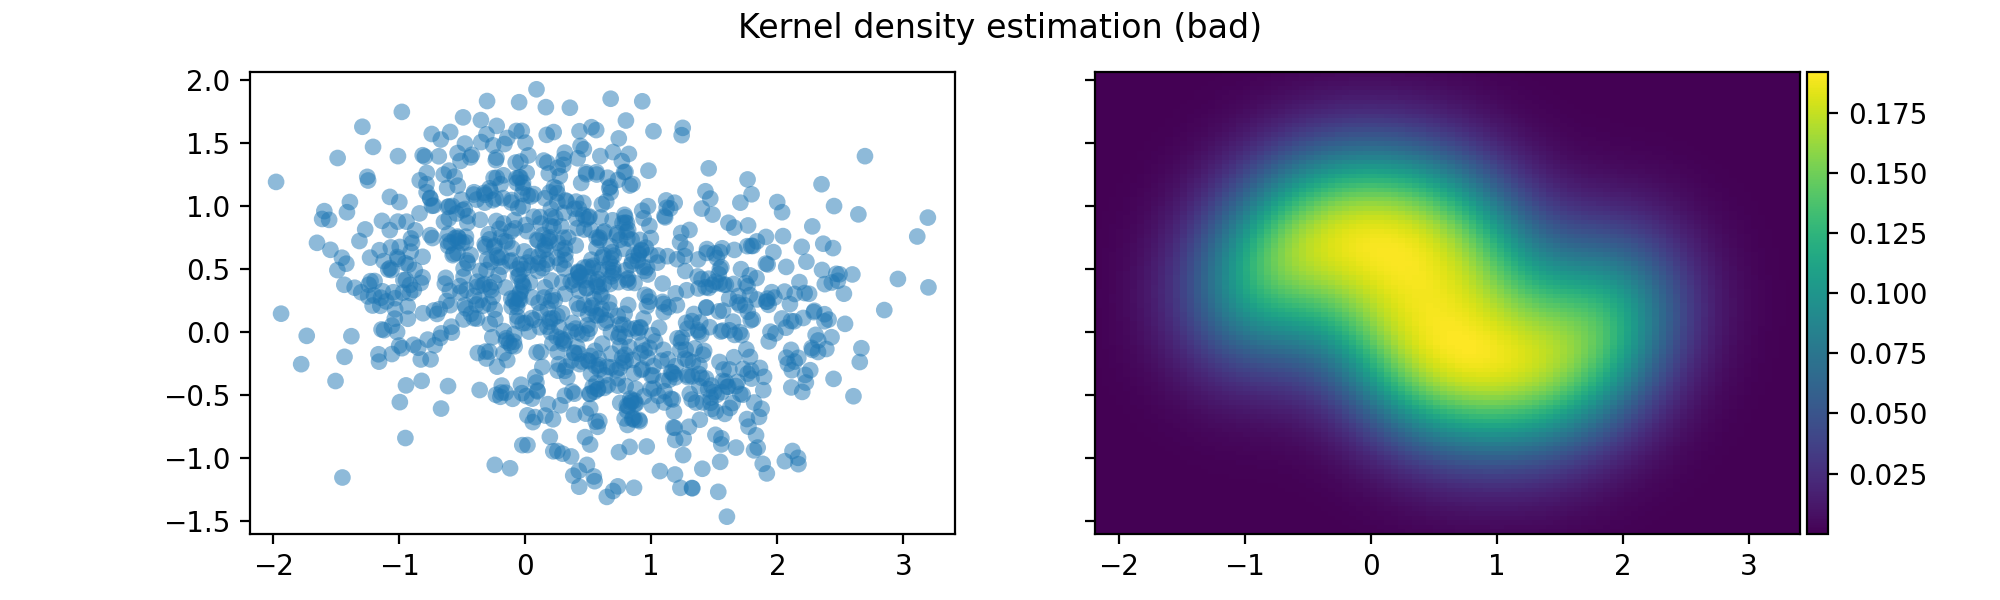

In [30]:
plot_model(models["KDE"][0.15565517241379312], "Kernel density estimation (bad)", rng)

# Exercise 2
## Higher-dimensional data

The same tasks as above were repeated for the digits dataset from sklearn. Instead of the histogram a density forest was used.

In [31]:
import sys

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity

sys.path.append("density_forest")

# %load_ext autoreload
# %autoreload 2
from DensityForest import DensityForest

In [32]:
data, target = load_digits(return_X_y=True)

In [33]:
trainingdata, testdata, trainingtarget, testtarget = train_test_split(
    data, target, test_size=0.1, random_state=42, stratify=target
)

In [34]:
randomForest = RandomForestClassifier(10, random_state=42, n_jobs=-1)
randomForest.fit(trainingdata, trainingtarget)
randomForest.score(trainingdata, trainingtarget)

1.0

In [35]:
randomForest.score(testdata, testtarget)

0.9722222222222222

## Note

We note that this implementation of density forests does not work with these data as-is: The data set is quite sparse, so that there is a high likelihood that after a split, one of the subsets will have only zeros in at least one dimension. This leads to a singular covariance matrix and zero information gain for al further splits, so splitting stops prematurely. To work around this problem, we perform PCA and use the first 40 principal components to train the random density forest. Samples from the density forest are transformed to coordinates in data space.

Moreover, this implementation of density forests has a hard-coded assumption that the data are 2-dimensional. Since we had to patch the implementation to remove this assumption, we also implemented random sampling directly in the density forest code. We are including our modified version with this submission. To ease grading, we are also including a diff file containing our changes.

### PCA

In [52]:
from sklearn.decomposition import PCA

In [53]:
pca = PCA(whiten=True)
pca.fit(data)

PCA(whiten=True)

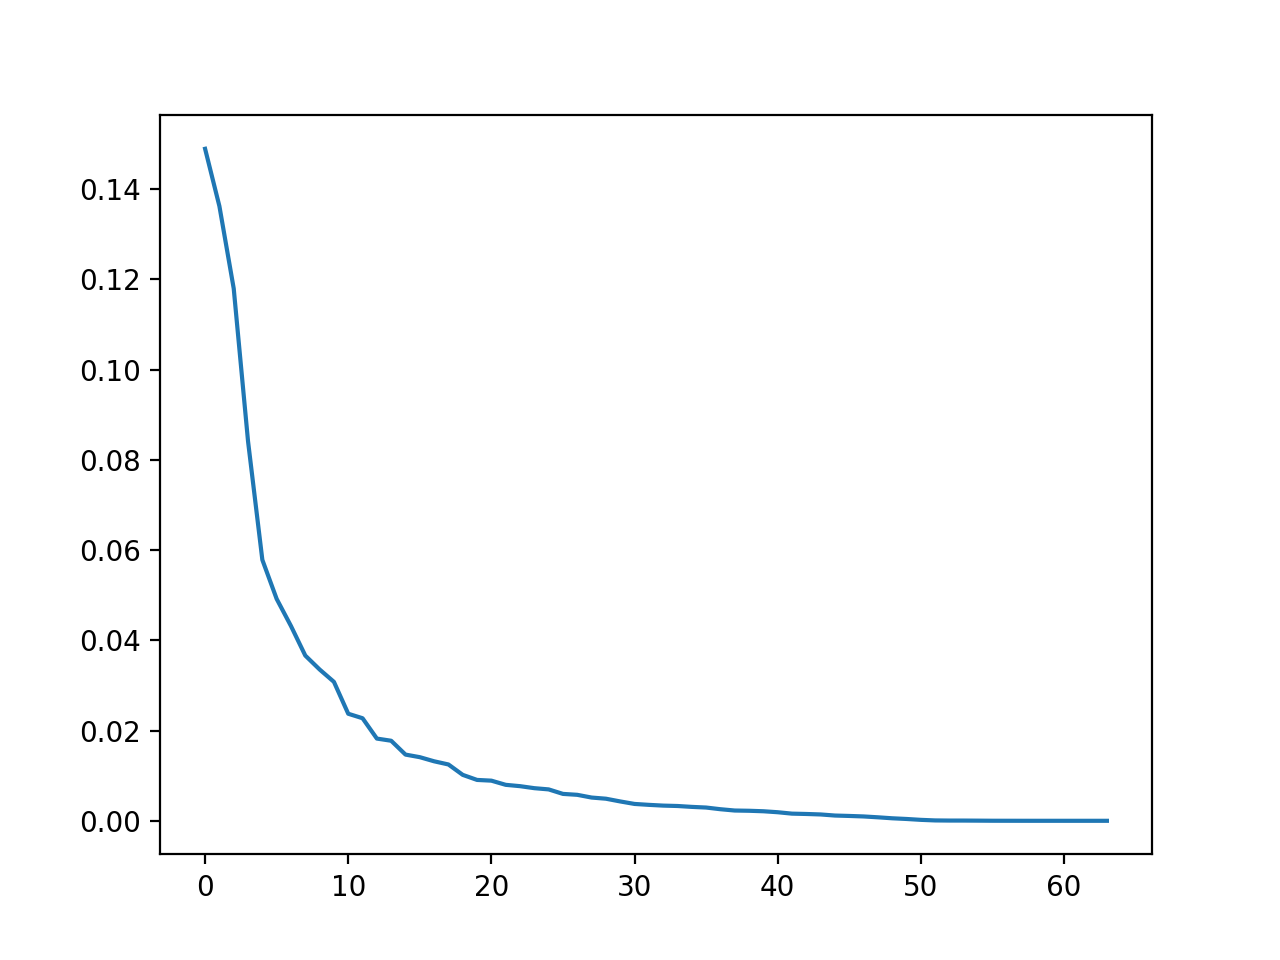

In [54]:
plt.plot(pca.explained_variance_ratio_)

## Evaluate different models on the digits dataset

* Kernel Density
* Gaussian Mixture Models
* Density Forest

In [59]:
skresults = []
skmodels = {}
mmd_bw = 1

training_sizes = np.round(np.linspace(0.2, 1, num=9) * trainingdata.shape[0]).astype(int)


def eval_skmodel(modelcls, params, param_name, do_pca=False, pca_ncomps=40):
    initargs, sampleargs = {}, {}
    ninitargs, nsampleargs = modelcls.__init__.__code__.co_argcount, modelcls.sample.__code__.co_argcount
    initargnames, sampleargnames = (
        modelcls.__init__.__code__.co_varnames[1:ninitargs],
        modelcls.sample.__code__.co_varnames[1:nsampleargs],
    )
    if "random_state" in initargnames:
        initargs["random_state"] = 42
    if "random_state" in sampleargnames:
        sampleargs["random_state"] = 42

    if do_pca:
        pca = PCA(whiten=True)
        pca.fit(trainingdata)
        tdata = pca.transform(trainingdata)[:, :pca_ncomps]
    else:
        tdata = trainingdata

    cmodels = {}
    for param in params:
        for ts_size in training_sizes:
            initargs[param_name] = param
            model = modelcls(**initargs)
            model.fit(tdata[:ts_size, :])
            msample = model.sample(testdata.shape[0], **sampleargs)
            if isinstance(msample, tuple):
                msample = msample[0]
            if do_pca:
                msample = pca.inverse_transform(
                    np.concatenate(
                        (msample, np.zeros((msample.shape[0], trainingdata.shape[1] - msample.shape[1]))), axis=1
                    )
                )

            mmd_sqexp = mmd(testdata, msample, SqExpKern(mmd_bw))
            mmd_multiquad = mmd(testdata, msample, MultiQuadKern(mmd_bw))

            skresults.append(
                {
                    "model": model.__class__.__name__,
                    "ts_size": ts_size,
                    "param": param,
                    "mmd_sqexp": mmd_sqexp,
                    "mmd_multiquad": mmd_multiquad,
                }
            )
        cmodels[param] = model
    skmodels[modelcls.__name__] = cmodels


eval_skmodel(KernelDensity, np.linspace(0.1, 10, num=100), "bandwidth")
eval_skmodel(GaussianMixture, np.arange(10, 201), "n_components")
eval_skmodel(DensityForest, (5, 10, 50, 100, 200), "n_estimators")

skresults = pd.DataFrame(skresults)

In [60]:
skresults.to_pickle("2_results.pkl")
pickle.dump(skmodels, open("2_models.pkl", "wb"))

In [61]:
skresults = pd.read_pickle("2_results.pkl")
skmodels = pickle.load(open("2_models.pkl", "rb"))

In [62]:
skresults = skresults.melt(id_vars=["model", "param", "ts_size"], var_name="mmd_type", value_name="mmd").assign(
    mmd_type=lambda x: x.mmd_type.str[4:]
)

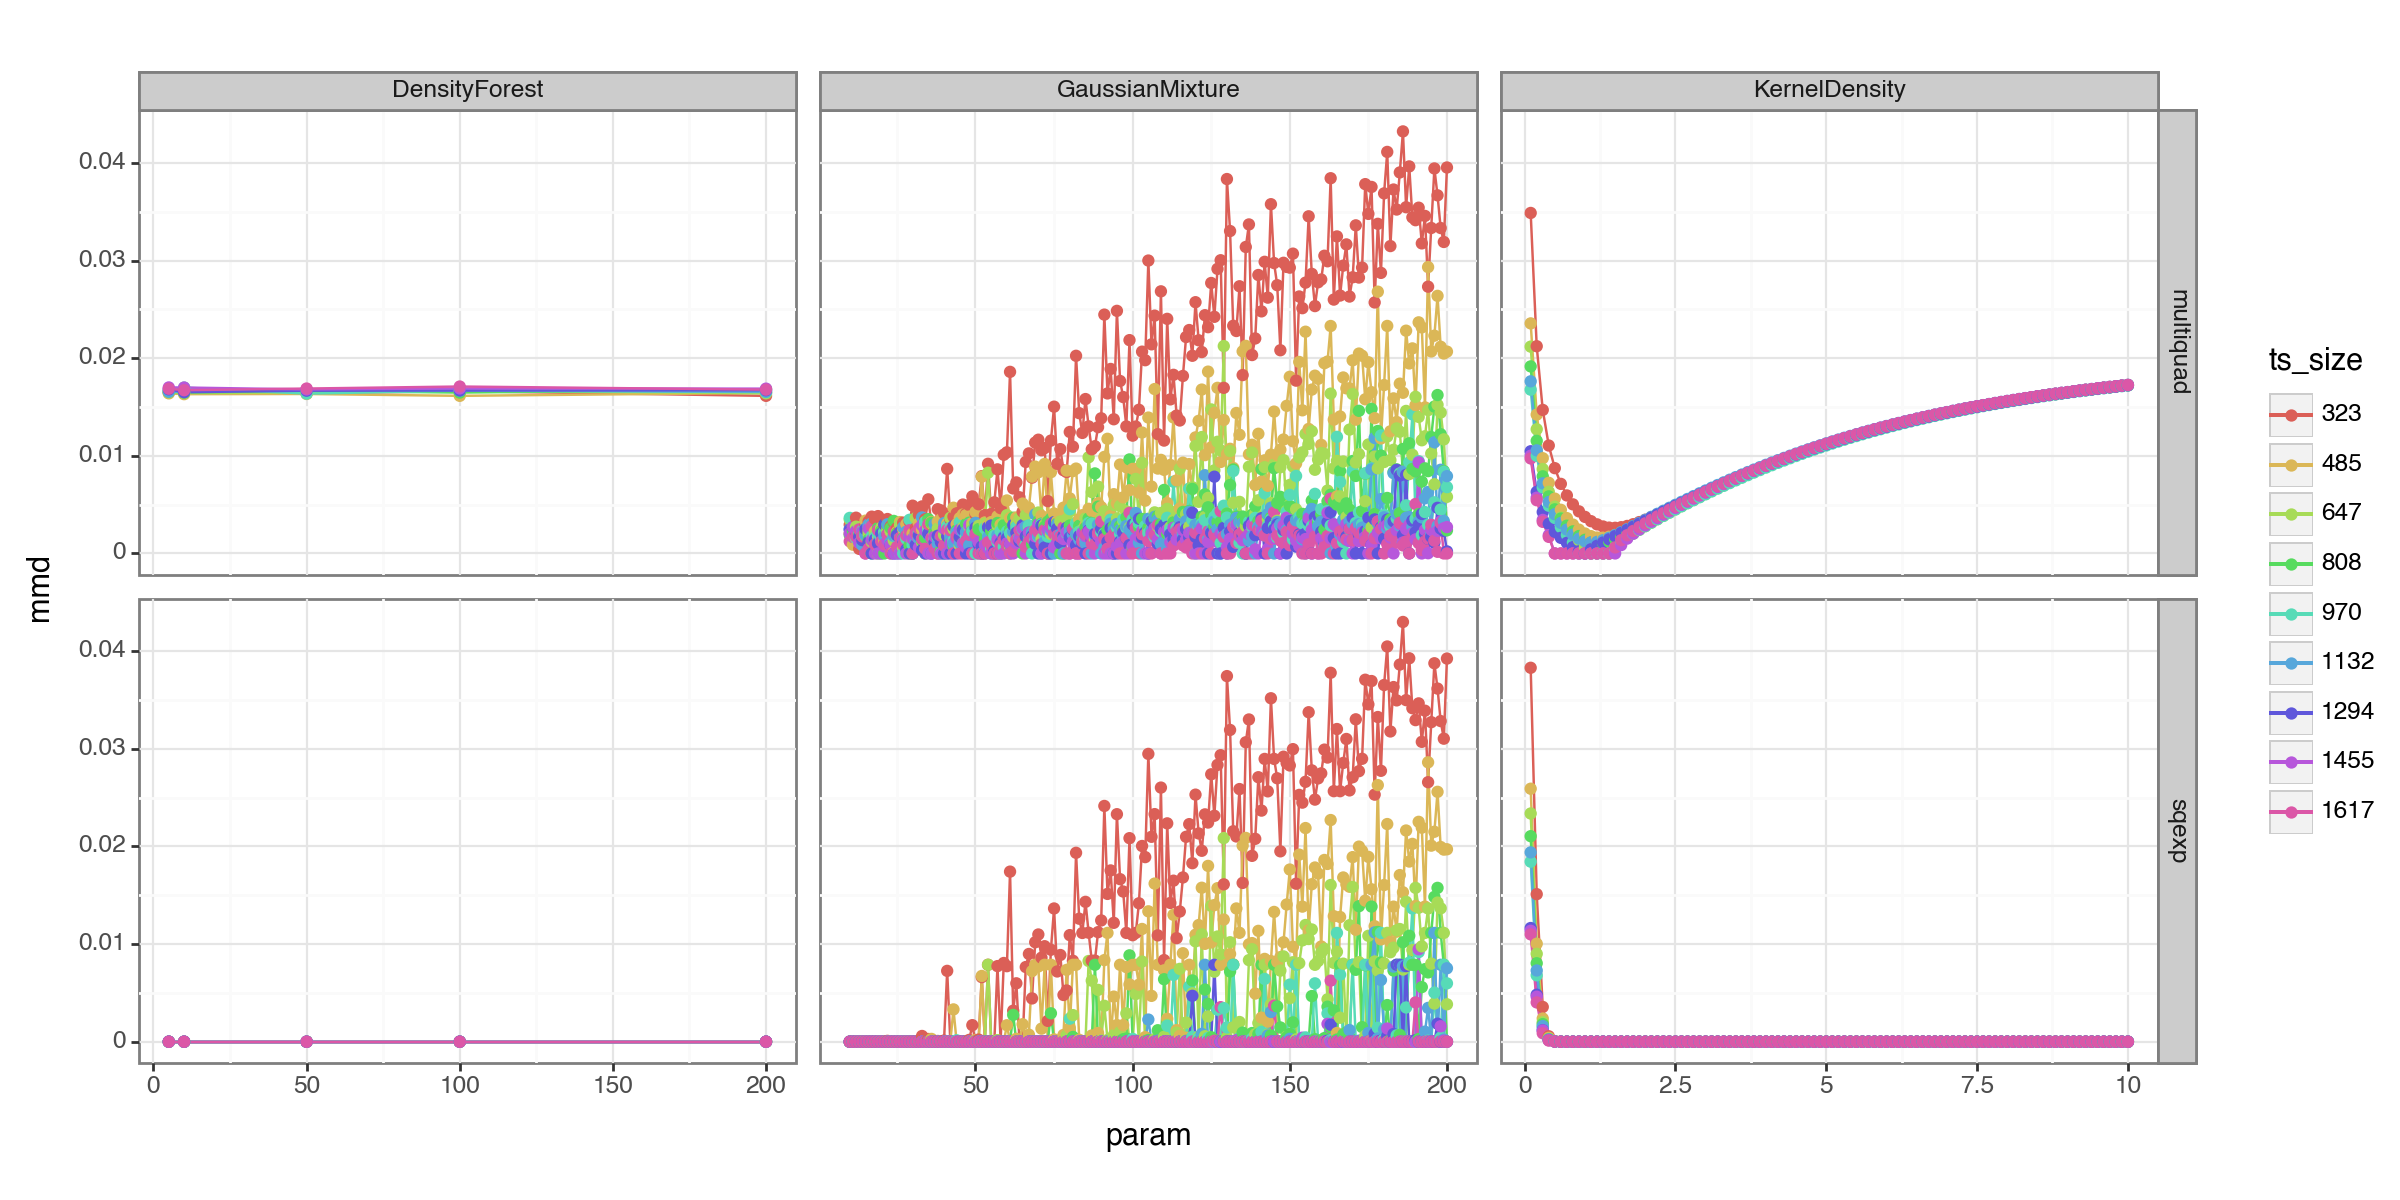

<Figure Size: (1200 x 600)>

In [63]:
(
    ggplot(
        skresults.assign(ts_size=lambda x: pd.Categorical(x.ts_size)),
        aes("param", "mmd", color="ts_size"),
    )
    + geom_line()
    + geom_point()
    + facet_grid(("mmd_type", "model"), scales="free_x")
    + theme(figure_size=(12, 6))
)

### Comments

Similar to the previous exercise, increased training set size improves model quality for the Gaussian mixture and KDE models. However, the density forest produces equally good models for all training set sizes and parameters tested. Since only the number of trees was varied, it is possible that other parameters affect the results more.

For the Gaussian mixture model, the effect of training set size becomes more evident as the number of mixture components increases. This is expected, as models with a high number of components and low training set sizes can assign only a few samples to each component, leading to high noise. For the largest training set size, when using the multi-quadratic MMD kernel, model quality increases until approx. 15 components and stays constant for larger component numbers.

The KDE model produces another curious result: While its quality starts to decrease as bandwidth increases above 2 when measured with the multi-quadratic kernel, the squared exponential kernel reports constant cood quality. This may be due to the chosen bandwidth used for the MMD kernels.

In [72]:
def plotmodelsamples(model_good, model_bad=None, nsamples=20):
    fig, axs = plt.subplots(
        2 if model_bad is not None else 1, nsamples, gridspec_kw={"wspace": 0, "hspace": 0}, squeeze=False
    )

    fig.set_size_inches(nsamples * 1, 2.5 if model_bad is not None else 1.5)

    sampleargs = {}
    nsampleargs = model_good.__class__.sample.__code__.co_argcount
    sampleargnames = model_good.__class__.sample.__code__.co_varnames[1:nsampleargs]
    if "random_state" in sampleargnames:
        sampleargs["random_state"] = 42

    goodsamples = model_good.sample(nsamples, **sampleargs)

    if isinstance(goodsamples, tuple):
        goodsamples = goodsamples[0]

    if model_bad is not None:
        badsamples = model_bad.sample(nsamples, **sampleargs)
        if isinstance(badsamples, tuple):
            badsamples = badsamples[0]
    else:
        badsamples = goodsamples

    vmin = np.minimum(goodsamples.min(), badsamples.min())
    vmax = np.maximum(goodsamples.max(), badsamples.max())
    for i, (ax, sample) in enumerate(zip(axs[0, :], goodsamples)):
        img = ax.imshow(sample.reshape((8, 8)), vmin=vmin, vmax=vmax)
        ax.set_xticks([])
        ax.set_yticks([])

    if model_bad is not None:
        for i, (ax, sample) in enumerate(zip(axs[1, :], badsamples)):
            ax.imshow(sample.reshape((8, 8)), vmin=vmin, vmax=vmax)
            ax.set_xticks([])
            ax.set_yticks([])

    l0, b0, w0, h0 = axs[0, -1].get_position().bounds
    l1, b1, w1, h1 = axs[1 if model_bad is not None else 0, -1].get_position().bounds
    cax = fig.add_axes((l0 + w0 + w0 * 0.1, b1, w0 * 0.1, (b0 - b1) + h0))
    fig.colorbar(img, fraction=1, cax=cax)

    if model_bad is not None:
        axs[0, 0].text(
            -0.3,
            0.5,
            "good",
            transform=axs[0, 0].transAxes,
            rotation="vertical",
            verticalalignment="center",
            fontsize="large",
        )
        axs[1, 0].text(
            -0.3,
            0.5,
            "bad",
            transform=axs[1, 0].transAxes,
            rotation="vertical",
            verticalalignment="center",
            fontsize="large",
        )

    fig.suptitle(f"samples from {model_good.__class__.__name__}")

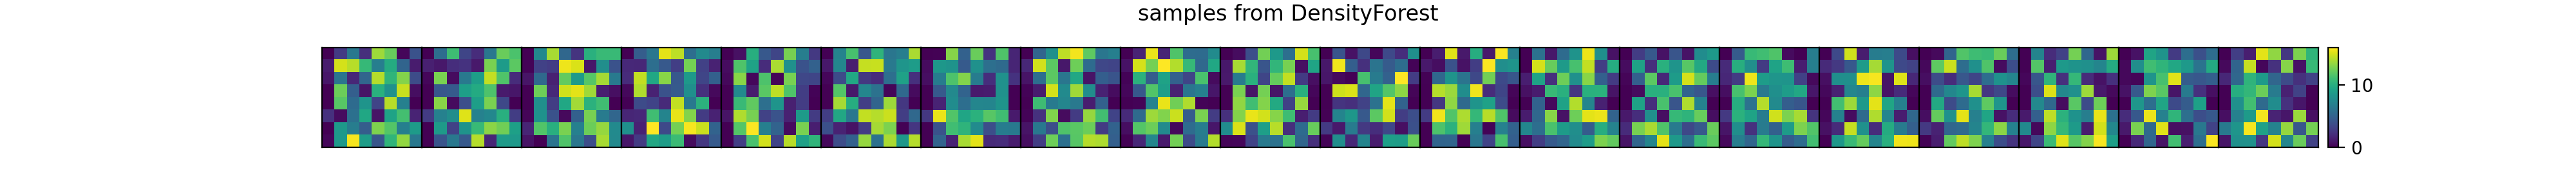

In [127]:
plotmodelsamples(skmodels["DensityForest"][10])

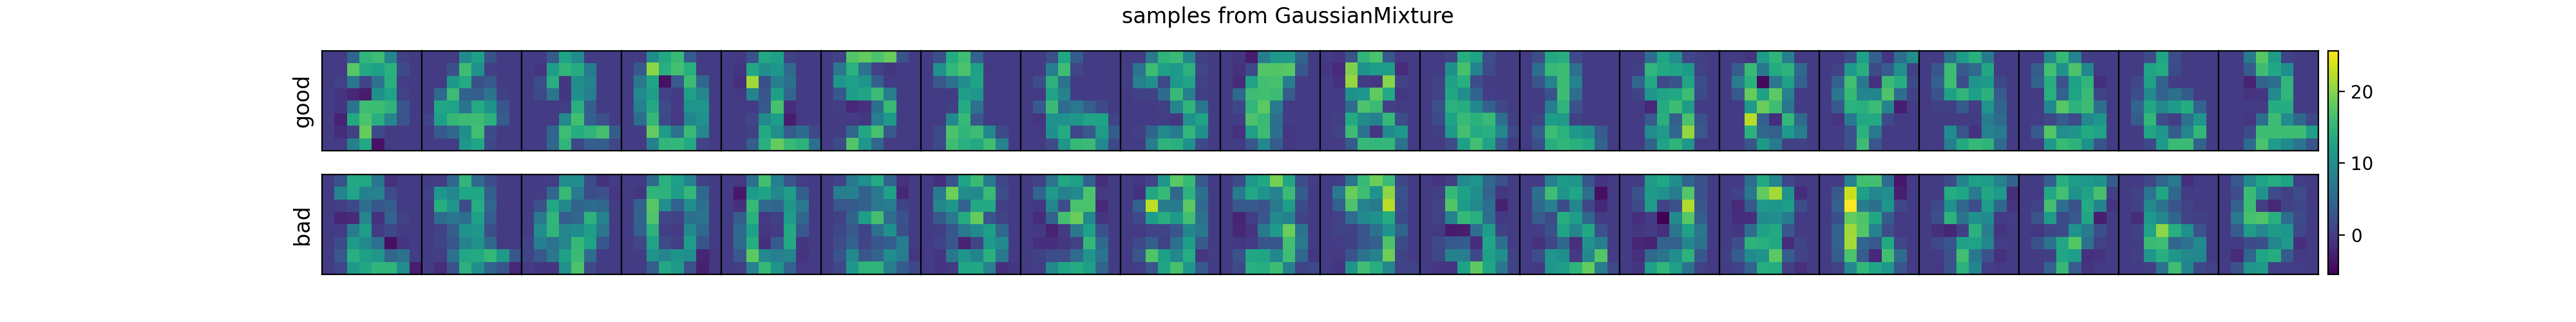

In [87]:
plotmodelsamples(skmodels["GaussianMixture"][200], skmodels["GaussianMixture"][10])

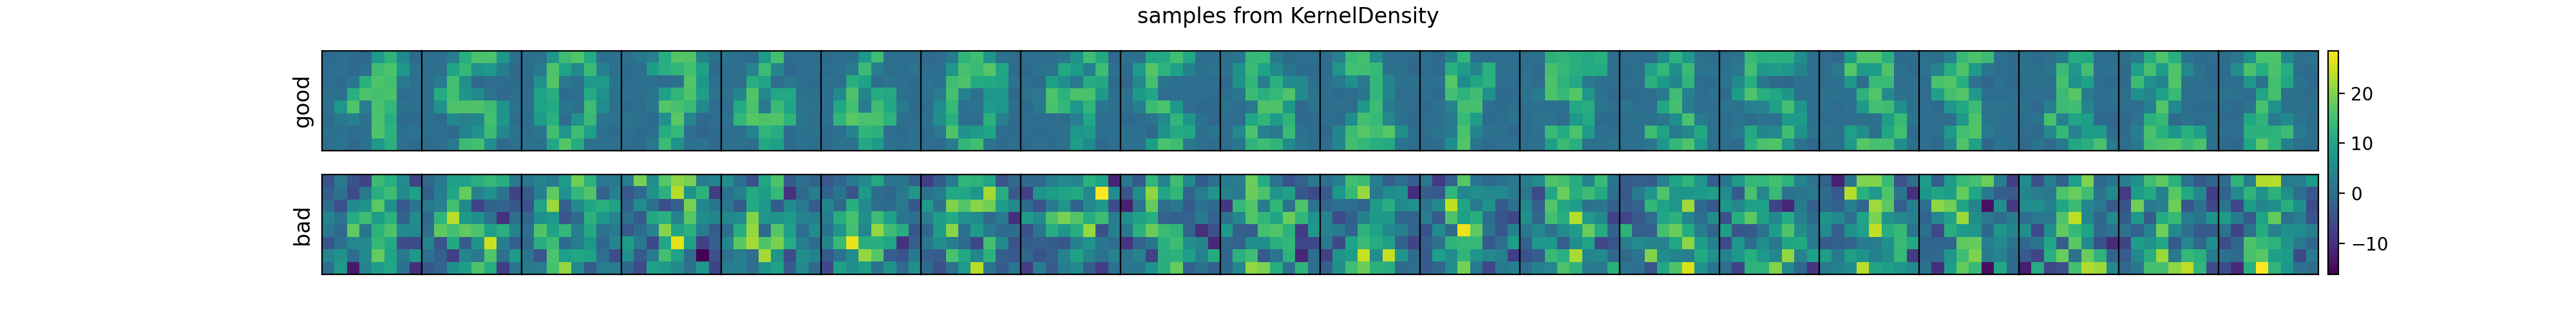

In [110]:
plotmodelsamples(skmodels["KernelDensity"][0.5], skmodels["KernelDensity"][5])

To quantitatively assess model quality, we use two metrics:

- The confidence of the random forest model in its prediction, i.e. the predicted probability of the highest-probability digit. For model-generated samples close to the training data, confidence should be high, while for samples that do not resemble training data, confidence should be low
- The proportion of each digit in the random sample. For samples that represent the training data well, approximately equal proportions of each digit are expected.

In [122]:
def plotmodelstats(model_good, model_bad=None, nsamples=1000):
    fig, axs = plt.subplots(2 if model_bad is not None else 1, 2, gridspec_kw={"hspace": 0}, squeeze=False)
    fig.set_size_inches(8, 8 if model_bad is not None else 4)

    sampleargs = {}
    nsampleargs = model_good.__class__.sample.__code__.co_argcount
    sampleargnames = model_good.__class__.sample.__code__.co_varnames[1:nsampleargs]
    if "random_state" in sampleargnames:
        sampleargs["random_state"] = 42

    goodsamples = model_good.sample(nsamples, **sampleargs)
    if isinstance(goodsamples, tuple):
        goodsamples = goodsamples[0]
    goodprediction = randomForest.predict_proba(goodsamples)
    axs[0, 0].hist(goodprediction.max(1), bins=10, density=True)
    digit, counts = np.unique(np.argmax(goodprediction, axis=1), return_counts=True)
    axs[0, 1].bar(digit, counts / counts.sum(), tick_label=digit)

    if model_bad is not None:
        badsamples = model_bad.sample(nsamples, **sampleargs)
        if isinstance(badsamples, tuple):
            badsamples = badsamples[0]
        badprediction = randomForest.predict_proba(badsamples)
        axs[1, 0].hist(badprediction.max(1), bins=10, density=True)
        digit, counts = np.unique(np.argmax(badprediction, axis=1), return_counts=True)
        axs[1, 1].bar(digit, counts / counts.sum(), tick_label=digit)

    for i in range(2 if model_bad is not None else 1):
        if model_bad is not None:
            axs[0, i].set_xticks([])
        axs[i, 0].set_ylabel("density")
        axs[i, 1].set_ylabel("fraction of samples")

    axs[1 if model_bad is not None else 0, 0].set_xlabel("max. prediction probability")
    axs[1 if model_bad is not None else 0, 1].set_xlabel("predicted digit")

    if model_bad is not None:
        axs[0, 0].text(
            -0.3,
            0.5,
            "good",
            transform=axs[0, 0].transAxes,
            rotation="vertical",
            verticalalignment="center",
            fontsize="large",
        )
        axs[1, 0].text(
            -0.3,
            0.5,
            "bad",
            transform=axs[1, 0].transAxes,
            rotation="vertical",
            verticalalignment="center",
            fontsize="large",
        )

    fig.suptitle(f"random forest prediction of samples from {model_good.__class__.__name__}")
    fig.tight_layout()

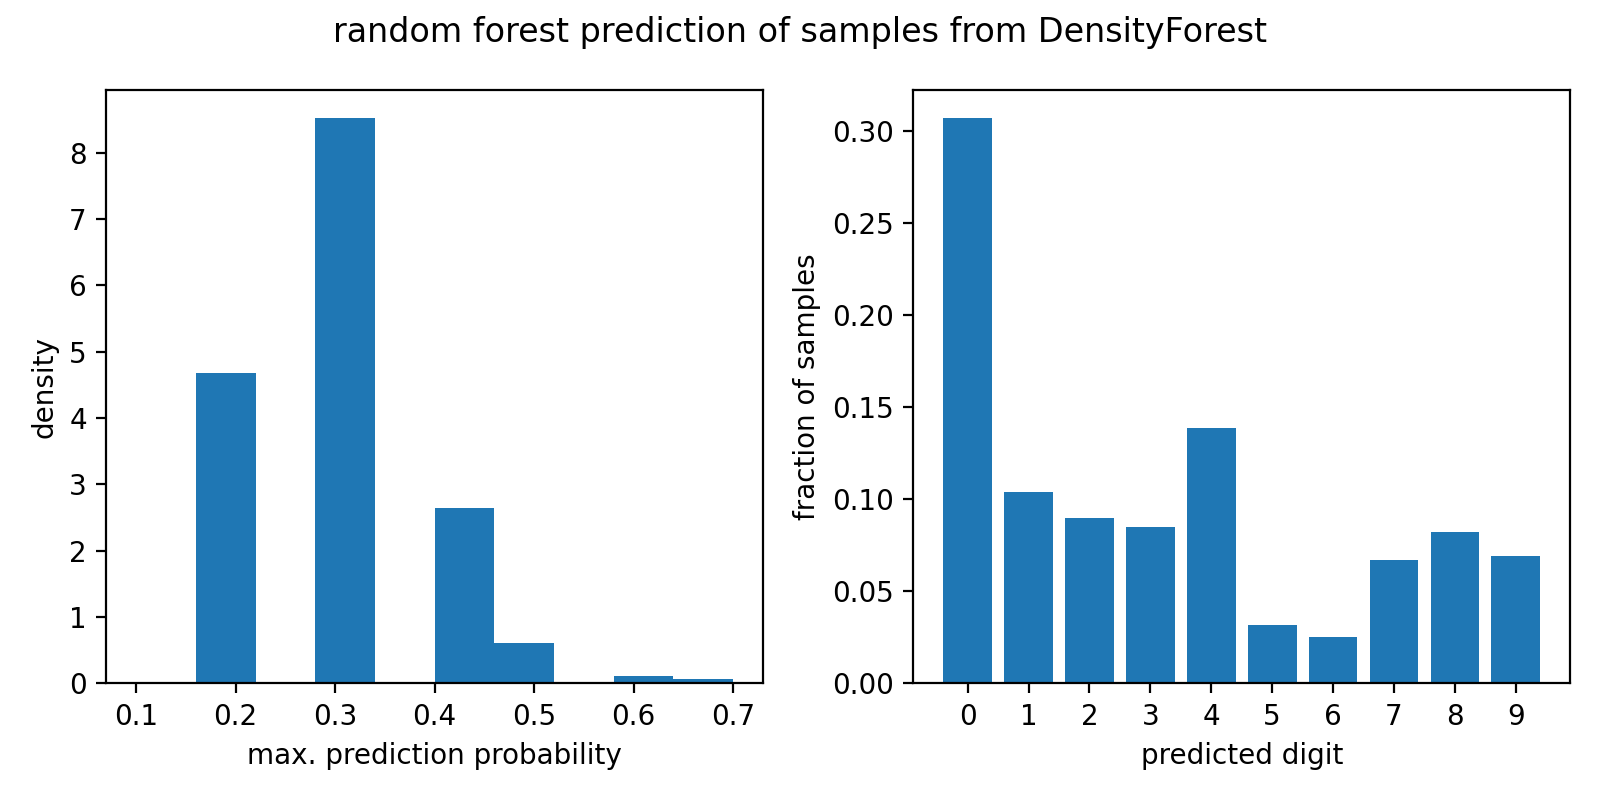

In [123]:
plotmodelstats(skmodels["DensityForest"][5])

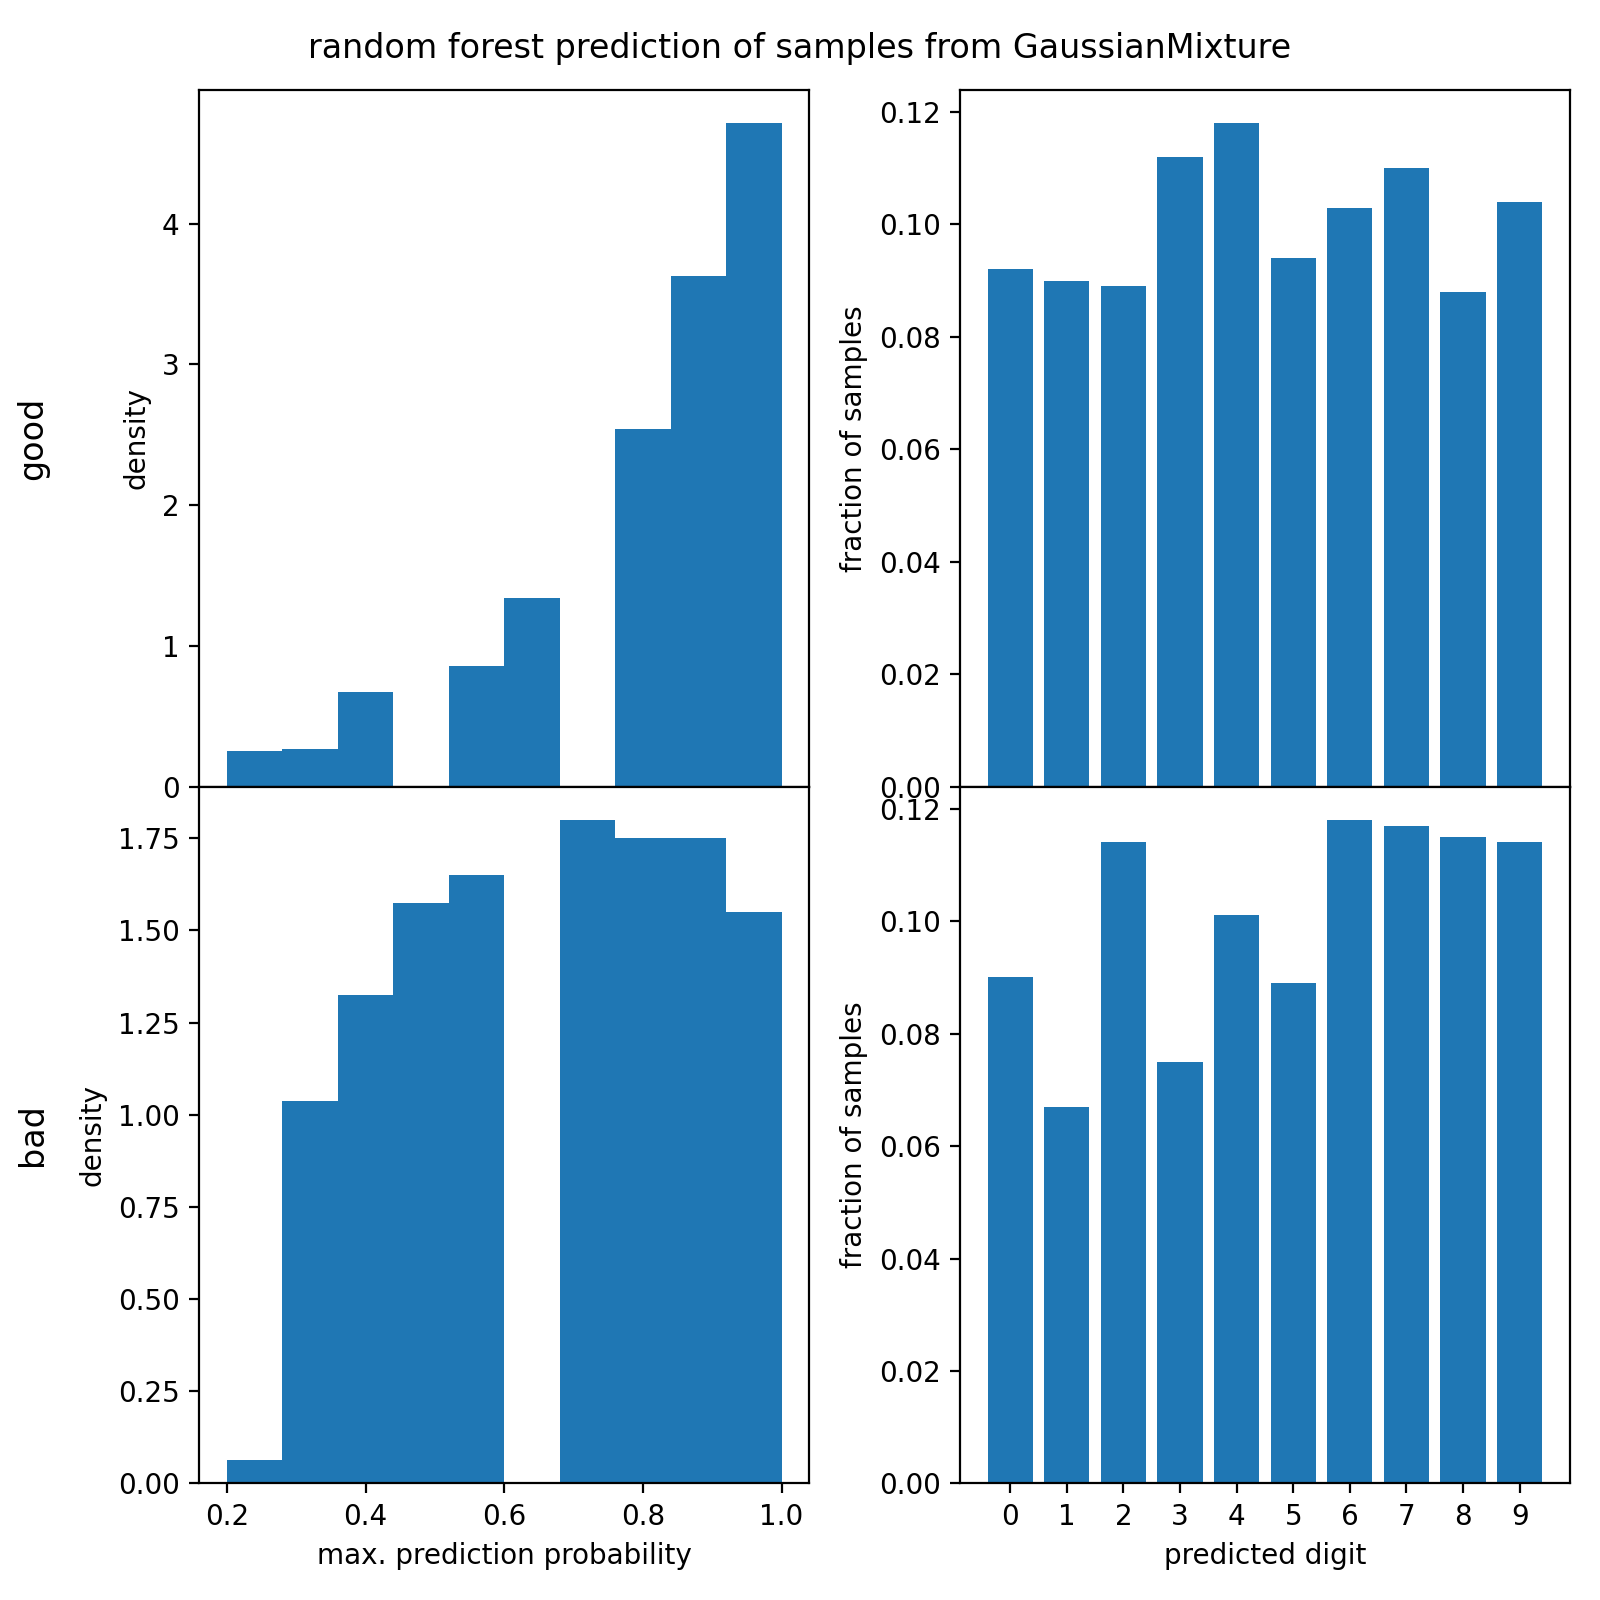

In [124]:
plotmodelstats(skmodels["GaussianMixture"][200], skmodels["GaussianMixture"][10])

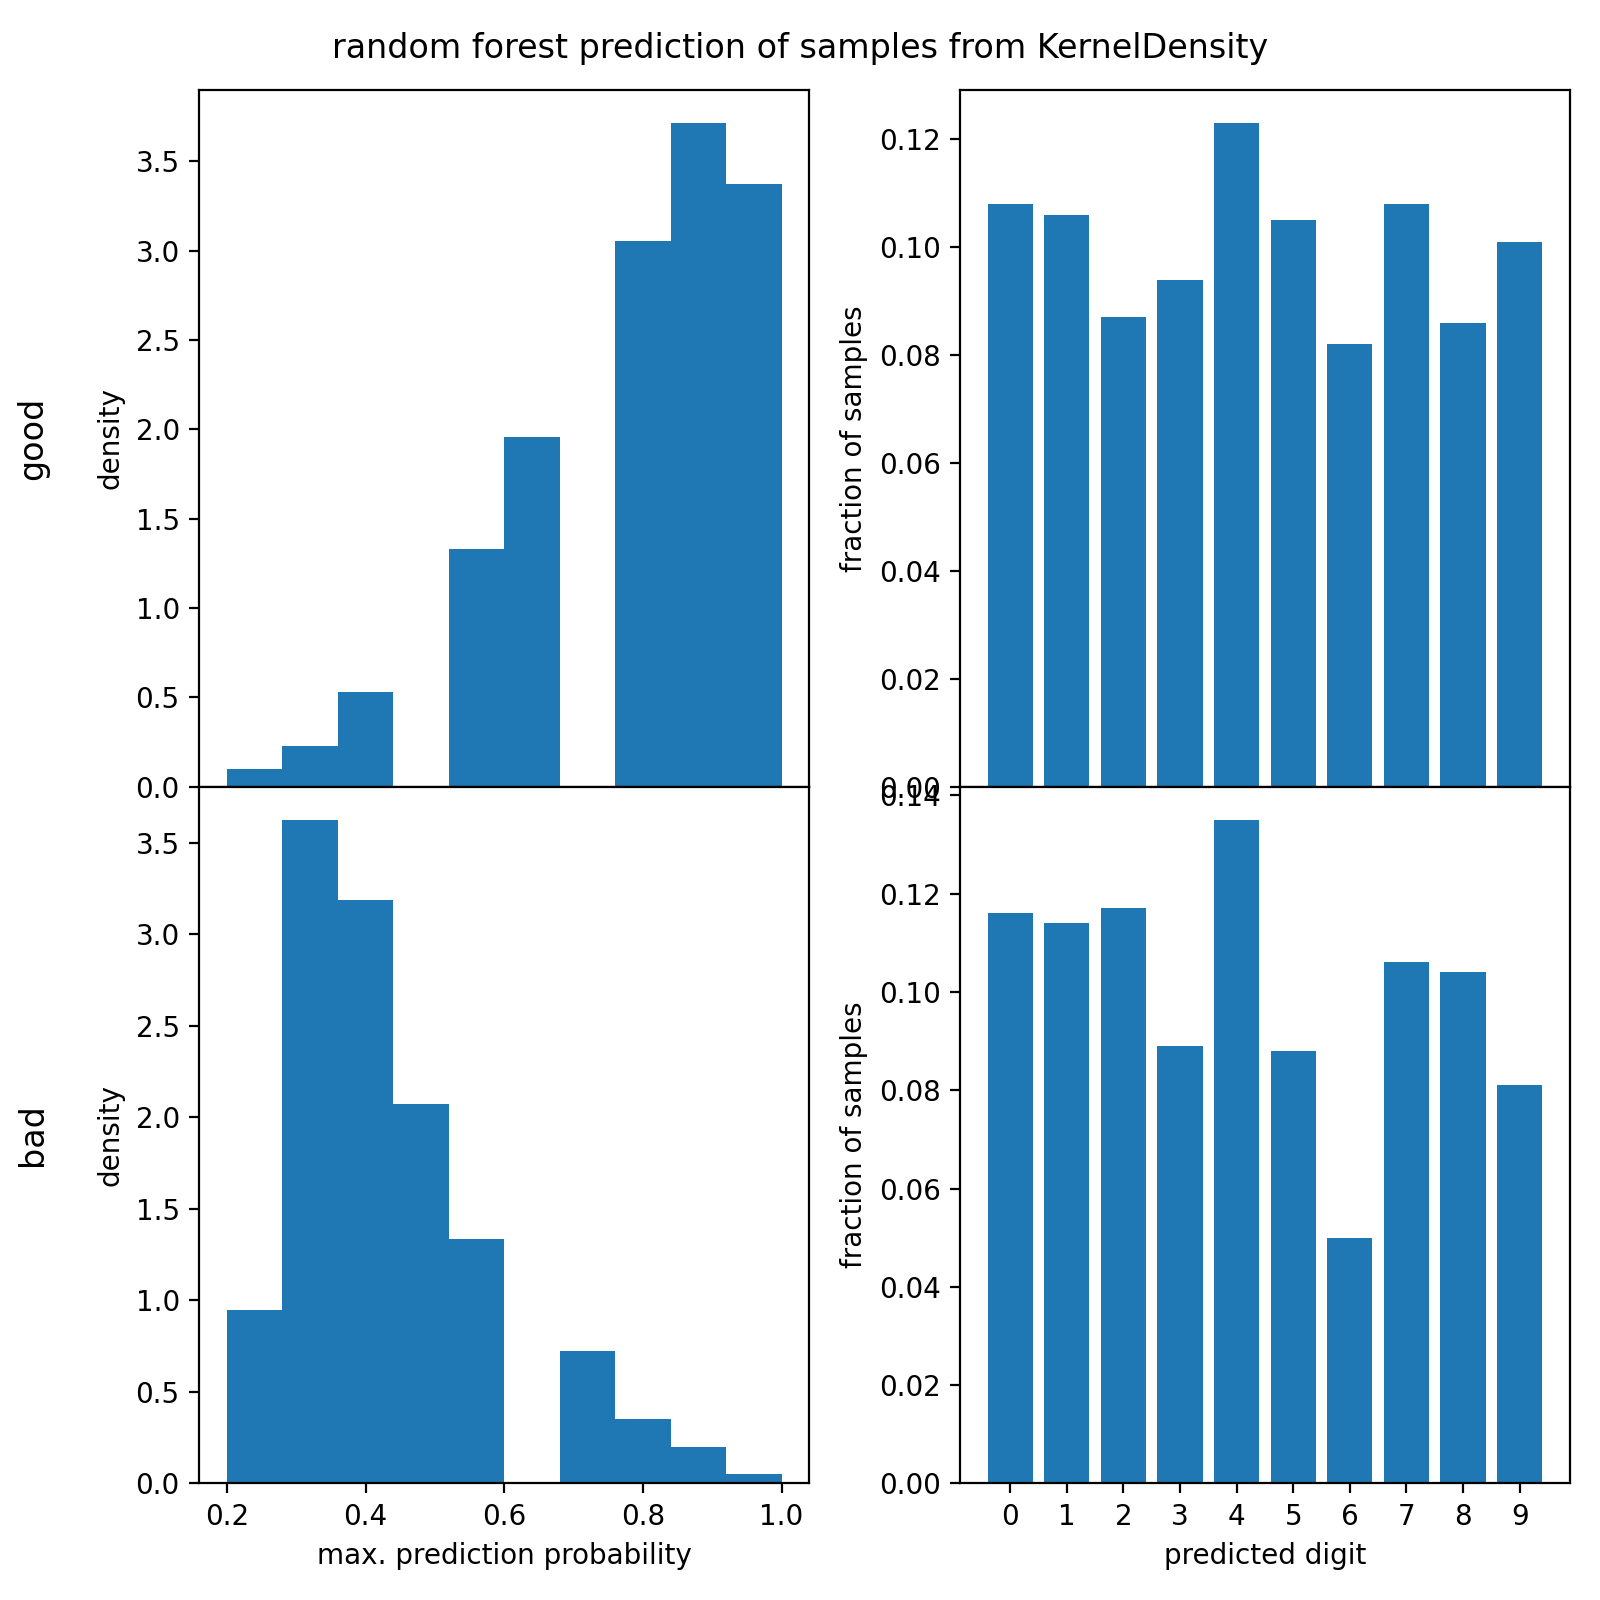

In [125]:
plotmodelstats(skmodels["KernelDensity"][0.5], skmodels["KernelDensity"][5])

The density forest is cleary the worst model in this setting. The random forest has very low confidence in its predictions, the digit proportions are very different, and the samples do not resemble digits by eye. This is consistent with its MMD when using the multi-quadratic kernel.

The Gaussian mixture is better for both parameter settings, with the good parameter setting having higher prediction confidence and more uniform digit distribution than the bad parameter setting. Interestingly, even though random samples from the bad Gaussian mixture model look very much like digits to the human eye, confidence of the random forest predictions is drastically lower than for the good model.

The good kernel density model is approximately comparable to the good Gaussian mixture model, while the bad kernel density model model is much worse than the bad Gaussian mixture model. This is also evident when looking at the samples by eye.